<a href="https://colab.research.google.com/github/OleksandrArtemenko/retail_business_analysis_portfolio/blob/main/project_shop_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade google-cloud-bigquery

In [2]:
pip install squarify

In [3]:
pip install scikit-posthocs

In [4]:
from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import squarify
from scipy.stats import pearsonr
import itertools
from scipy.stats import shapiro, ttest_ind, mannwhitneyu, kruskal, chi2_contingency
import scikit_posthocs as sp
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
plt.style.use('bmh')
sns.set_palette('viridis')
plt.rcParams.update({'font.size': 10})

In [5]:
# # Версія коду, яка використовувалась початково для вивантаження даних, але яка не буде працювати без відповідних прав
# auth.authenticate_user()
# client = bigquery.Client(project="data-analytics-mate")

In [7]:
# Версія коду, яка використовувалась початково для вивантаження даних, але яка не буде працювати без відповідних прав
query = """
SELECT
  s.date,
  o.ga_session_id,
  sp.continent,
  sp.country,
  sp.device,
  sp.browser,
  sp.mobile_model_name,
  sp.operating_system,
  sp.language,
  sp.name AS channel_info,
  sp.channel,
  acs.account_id,
  ac.is_verified,
  ac.is_unsubscribed,
  p.category,
  p.name AS product_name,
  p.price,
  p.short_description
FROM `data-analytics-mate.DA.order` o
JOIN `data-analytics-mate.DA.product` p
USING (item_id)
JOIN `data-analytics-mate.DA.session` s
USING (ga_session_id)
JOIN `data-analytics-mate.DA.session_params` sp
USING (ga_session_id)
LEFT JOIN `data-analytics-mate.DA.account_session` acs
USING (ga_session_id)
LEFT JOIN `data-analytics-mate.DA.account` ac
ON acs.account_id = ac.id
"""

In [11]:
# # Версія коду, яка використовувалась початково для вивантаження даних, але яка не буде працювати без відповідних прав
# query_job = client.query(query)
# results = query_job.result()
# df = results.to_dataframe()

In [13]:
# # Версія коду, яка вивантажує дані із готового csv файлу, якщо він завантажений разом із файлом проекту
# df = pd.read_csv('dataset_furniture_business.csv')

In [16]:
# Версія коду, яка вивантажує дані із готового csv файлу
url = 'https://drive.google.com/uc?id=1KsgfnMTp3D_n3PwVz-J6cnyIxYK_fHbV'
df = pd.read_csv(url)

In [ ]:
df.head()

,date,ga_session_id,continent,country,device,browser,mobile_model_name,operating_system,language,channel_info,channel,account_id,is_verified,is_unsubscribed,category,product_name,price,short_description
0,2020-11-06,7799937037,Europe,Slovakia,mobile,Chrome,<Other>,Web,fr,(referral),Paid Search,<NA>,<NA>,<NA>,Children's furniture,TROFAST,5.0,"Lid, 20x28 cm"
1,2020-11-10,4020421879,Americas,United States,desktop,Chrome,Safari,Macintosh,en,(direct),Direct,653378,1,0,Children's furniture,TROFAST,5.0,"Lid, 20x28 cm"
2,2020-11-24,6717382496,Americas,United States,desktop,Chrome,Chrome,Web,en-us,(referral),Social Search,<NA>,<NA>,<NA>,Children's furniture,TROFAST,5.0,"Lid, 20x28 cm"
3,2020-11-26,2093497337,Americas,United States,desktop,Chrome,Chrome,Web,en-us,(direct),Direct,<NA>,<NA>,<NA>,Children's furniture,TROFAST,5.0,"Lid, 20x28 cm"
4,2020-12-03,9506718330,Europe,Spain,desktop,Chrome,ChromeBook,<Other>,en-us,(referral),Paid Search,<NA>,<NA>,<NA>,Children's furniture,TROFAST,5.0,"Lid, 20x28 cm"


In [ ]:
print(list(df.columns))

['date', 'ga_session_id', 'continent', 'country', 'device', 'browser', 'mobile_model_name', 'operating_system', 'language', 'channel_info', 'channel', 'account_id', 'is_verified', 'is_unsubscribed', 'category', 'product_name', 'price', 'short_description']


In [ ]:
df_initial = df.copy(deep=True)

**1. На першому етапі дослідження проведемо ознайомлення з даними - розмірністю, форматами, наявністю пропущених значень тощо. Також проведемо поверховий огляд основних параметрів тих чи інших характеристик у датасеті.
Загалом, наявний датасет представляє собою дані щодо продажів інтернет-магазину меблів і містить інформацію щодо параметрів сесій користувачів-покупців товарів та інформацію про реалізовані продукти.**

- Розміри датасету


In [ ]:
df.shape

(33538, 18)

- Наявність пропущених значень

In [ ]:
na_amount = df.isna().sum().sort_values(ascending=False)
na_amount

,0
is_unsubscribed,30757
is_verified,30757
account_id,30757
language,11007
ga_session_id,0
date,0
browser,0
continent,0
device,0
country,0


In [ ]:
na_pct = df.isna().sum() / len(df) * 100
na_pct.sort_values(ascending=False)
pd.concat([na_amount, na_pct], axis=1)

,0,1
is_unsubscribed,30757,91.707913
is_verified,30757,91.707913
account_id,30757,91.707913
language,11007,32.819488
ga_session_id,0,0.000000
date,0,0.000000
browser,0,0.000000
continent,0,0.000000
device,0,0.000000
country,0,0.000000


Бачимо, що більшість покупців не є зареєстрованими. Окрім цього, відсутня інформація щодо мови девайсу користувача для частини випадків.

In [ ]:
no_lang_device = df[df['language'].isna()]['device'].value_counts()
lang_device = df[~df['language'].isna()]['device'].value_counts()
pd.concat([lang_device, no_lang_device], axis=1)

,count,count
device,,
desktop,13228,6474
mobile,8824,4289
tablet,479,244


Отже, відсутній чіткий паттерн відсутності мови серед девайсів, тобто немає окремої проблеми з конкретним девайсом. Для зручності відмітими дані випадки як випадки з невизначеною мовою.

In [ ]:
df.fillna({'language': 'lang-undefined'}, inplace=True)

Також позначимо відсутні дані, пов'язані з аккаунтом.

In [ ]:
na_acc_cols = ['account_id', 'is_unsubscribed', 'is_verified']

for col in na_acc_cols:
  df[col] = df[col].astype('object').fillna('not_registered')

Перевіримо наявність пропущених значень зараз.

In [ ]:
df.isna().sum().sum()

np.int64(0)

- Наявність повних дублікатів

In [ ]:
df.duplicated().value_counts()

,count
False,33538


- Огляд типів даних

In [ ]:
df.dtypes

,0
date,dbdate
ga_session_id,Int64
continent,object
country,object
device,object
browser,object
mobile_model_name,object
operating_system,object
language,object
channel_info,object


Можемо побачити, що деякі типи даних можна оптимізувати для подальшої роботи.

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['date'].dtype

dtype('<M8[ns]')

In [ ]:
numeric_dtype = df.select_dtypes(include=['int', 'float']).columns
print(list(numeric_dtype))

['ga_session_id', 'price']


In [ ]:
df.select_dtypes(include=['int', 'float']).nunique().sort_values(ascending=False)

,0
ga_session_id,33538
price,829


In [ ]:
object_dtype = df.select_dtypes(include=['object']).columns
print(list(object_dtype))

['continent', 'country', 'device', 'browser', 'mobile_model_name', 'operating_system', 'language', 'channel_info', 'channel', 'account_id', 'is_verified', 'is_unsubscribed', 'category', 'product_name', 'short_description']


In [ ]:
df.select_dtypes(include=['object']).nunique().sort_values(ascending=False)

,0
account_id,2782
short_description,1476
product_name,550
country,108
category,14
language,10
mobile_model_name,10
continent,6
operating_system,6
browser,6


Окрім цього, конвертуємо частину характеристик у категоріальні дані для більш ефективної роботи з датасетом з точки зору операцій з даними. Візьмемо показник у 5% унікальних значень від загального розміру датасету як граничний: ті характеристики, унікальні значення в яких менші за вказаний обсяг, отримають категоріальний тип даних.

In [ ]:
threshold = 0.05
for col in df.select_dtypes(include='object').columns:
    if df[col].nunique() / len(df) < threshold:
        df[col] = df[col].astype('category')

In [ ]:
category_dtype = df.select_dtypes(include=['category']).columns
print(list(category_dtype))

['continent', 'country', 'device', 'browser', 'mobile_model_name', 'operating_system', 'language', 'channel_info', 'channel', 'is_verified', 'is_unsubscribed', 'category', 'product_name', 'short_description']


In [ ]:
df.select_dtypes(include=['category']).nunique().sort_values(ascending=False)

,0
short_description,1476
product_name,550
country,108
category,14
language,10
mobile_model_name,10
browser,6
operating_system,6
continent,6
channel_info,5


Знову виведемо загальний перелік типів даних з урахуванням застосованих змін.

In [ ]:
df.dtypes

,0
date,datetime64[ns]
ga_session_id,Int64
continent,category
country,category
device,category
browser,category
mobile_model_name,category
operating_system,category
language,category
channel_info,category


- Огляд основних показників різних типів даних

In [ ]:
df.describe(include=['datetime64[ns]', 'int', 'float'])

,date,ga_session_id,price
count,33538,33538.0,33538.000000
mean,2020-12-14 15:09:05.506589696,4964900683.146312,953.298679
min,2020-11-01 00:00:00,330355.0,3.000000
25%,2020-11-25 00:00:00,2476893918.0,170.000000
50%,2020-12-13 00:00:00,4961245290.0,445.000000
75%,2021-01-06 00:00:00,7442296865.75,1195.000000
max,2021-01-27 00:00:00,9999754183.0,9585.000000
std,NaN,2884281407.544152,1317.001775


Із вказаної таблиці можемо побачити спред по ціні (від 3 до 9585), а також те, що більшість замовлень не перевищують ціну у 1200 (75% = 1195). Окрім цього, бачимо часові рамки для даних у датасеті.

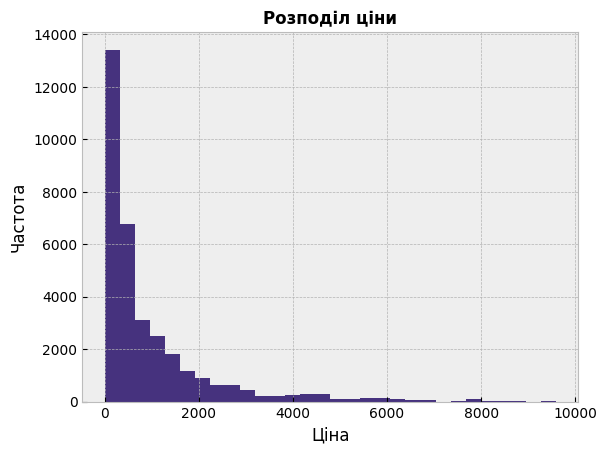

In [ ]:
plt.hist(df['price'], bins=30)
plt.xlabel('Ціна')
plt.ylabel('Частота')
plt.title('Розподіл ціни', fontsize=12, fontweight='bold')

plt.show()

Бачимо, що графік має позитивну асиметрію, хвіст графіку розтягнутий вправо.

In [ ]:
print(f'Початкова дата: {df["date"].min()}')
print(f'Кінцева дата: {df["date"].max()}')
print(f'Тривалість: {(df["date"].max() - df["date"].min()).days} днів')

Початкова дата: 2020-11-01 00:00:00
Кінцева дата: 2021-01-27 00:00:00
Тривалість: 87 днів


In [ ]:
df.describe(include=['object', 'category'])

,continent,country,device,browser,mobile_model_name,operating_system,language,channel_info,channel,account_id,is_verified,is_unsubscribed,category,product_name,short_description
count,33538,33538,33538,33538,33538,33538,33538,33538,33538,33538,33538,33538,33538,33538,33538
unique,6,108,3,6,10,6,10,5,5,2782,3,3,14,550,1476
top,Americas,United States,desktop,Chrome,Chrome,Web,en-us,(organic),Organic Search,not_registered,not_registered,not_registered,Bookcases & shelving units,BESTÅ,Chair
freq,18553,14673,19702,23015,9359,19537,15311,11430,11921,30757,30757,30757,7630,1257,659


Із даної таблиці видно, що основний ринок компанії - американський. Покупці в основному замовляють через персональний комп'ютер, залучаються органічним пошуком.

Основні висновки першого етапу:
- Датасет містить 33538 рядків, має 18 характеристик. Датасет охоплює дані за майже 3 місяці;
- Виявлені та змінені відсутні значення;
- Оптимізовані типи даних;
- Проведений огляд основних параметрів як для числових, так і категоріальних даних.

**2. На другому етапі дослідження більш детально ознайомимося із різними характеристиками з метою отримання уявлення про функціонування цього бізнесу та виявлення точок, які можуть стати предметом подальшого дослідження для підвищення ефективності діяльності компанії.**

- Аналіз продажів у розрізі континентів

In [ ]:
sales_by_continent = (
    df.groupby(['continent'], observed=True)['price']
    .agg(orders='count', total_sales='sum', avg_sales='mean')
    .reset_index()
    .sort_values(by='total_sales', ascending=False)
    .reset_index(drop=True)
)

sales_by_continent['avg_sales'] = sales_by_continent['avg_sales'].round(2)
sales_by_continent['sales_pct'] = ((sales_by_continent['total_sales'] / sales_by_continent['total_sales'].sum()) * 100).round(2)

sales_by_continent.style\
    .set_caption('Розподіл продажів та кількості замовлень за континентами')\
    .format({
        'total_sales': '{:.2f}',
        'avg_sales': '{:.2f}',
        'sales_pct': '{:.2f}%'
    })

,continent,orders,total_sales,avg_sales,sales_pct
0,Americas,18553,17665280.00,952.15,55.25%
1,Asia,7950,7601298.30,956.14,23.78%
2,Europe,6261,5934624.20,947.87,18.56%
3,Oceania,364,365230.20,1003.38,1.14%
4,Africa,339,331231.00,977.08,1.04%
5,(not set),71,74067.40,1043.20,0.23%


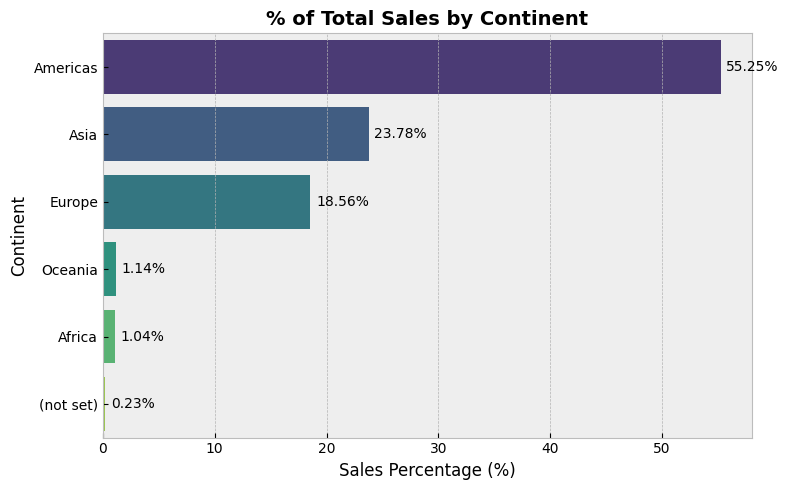

In [ ]:
sales_by_continent['continent'] = pd.Categorical(
    sales_by_continent['continent'],
    categories=sales_by_continent.sort_values('sales_pct', ascending=False)['continent'].tolist(),
    ordered=True
)

sales_by_continent = sales_by_continent.sort_values('continent')

plt.figure(figsize=(8, 5))
sns.barplot(data=sales_by_continent, x='sales_pct', y='continent', hue='continent', palette='viridis')

plt.title('% of Total Sales by Continent', fontsize=14, fontweight='bold')
plt.xlabel('Sales Percentage (%)')
plt.ylabel('Continent')

for index, value in enumerate(sales_by_continent['sales_pct']):
    plt.text(value + 0.5, index, f'{value}%', va='center')

plt.tight_layout()
plt.show()


Маємо підвердження, що компанія оперує переважно на американському ринку (55.25%), решта продажів в основному розподілена між Азією та Європою (23.78% та 18.56% відповідно).

- Аналіз продажів у розрізі країн

In [ ]:
orders_per_country = df.groupby('country', observed=True)['ga_session_id'].count().reset_index(name='orders').sort_values(by='orders', ascending=False).reset_index(drop=True)
orders_per_country['pct_from_total_orders'] = ((orders_per_country['orders'] / orders_per_country['orders'].sum()) * 100).round(2)
orders_per_country.style\
    .set_caption('Розподіл кількості замовлень за країнами')\
    .format({
        'pct_from_total_orders': '{:.2f}%'
    })

,country,orders,pct_from_total_orders
0,United States,14673,43.75%
1,India,3029,9.03%
2,Canada,2560,7.63%
3,United Kingdom,1029,3.07%
4,France,678,2.02%
5,Spain,658,1.96%
6,Germany,642,1.91%
7,China,600,1.79%
8,Taiwan,564,1.68%
9,Japan,454,1.35%


In [ ]:
sales_per_country = df.groupby('country', observed=True)['price'].sum().reset_index(name='total_sales').sort_values(by='total_sales', ascending=False).reset_index(drop=True)
sales_per_country['pct_from_total_sales'] = ((sales_per_country['total_sales'] / sales_per_country['total_sales'].sum()) * 100).round(2)
sales_per_country.style\
    .set_caption('Розподіл продажів за країнами')\
    .format({
        'total_sales': '{:.2f}',
        'pct_from_total_sales': '{:.2f}%'
    })

,country,total_sales,pct_from_total_sales
0,United States,13943553.90,43.61%
1,India,2809762.00,8.79%
2,Canada,2437921.00,7.63%
3,United Kingdom,938317.90,2.93%
4,France,710692.80,2.22%
5,Spain,631546.70,1.98%
6,Germany,599221.40,1.87%
7,China,588329.60,1.84%
8,Taiwan,552710.30,1.73%
9,Singapore,456447.20,1.43%


In [ ]:
top_orders = orders_per_country.nlargest(5, 'orders').sort_values(by='orders', ascending=False).reset_index(drop=True)
top_sales = sales_per_country.nlargest(5, 'total_sales').sort_values(by='total_sales', ascending=False).reset_index(drop=True)

In [ ]:
other_orders = orders_per_country.nsmallest(len(orders_per_country) - 5, 'orders')['orders'].sum()
other_orders_pct = orders_per_country.nsmallest(len(orders_per_country) - 5, 'orders')['pct_from_total_orders'].sum()

other_sales = sales_per_country.nsmallest(len(sales_per_country) - 5, 'total_sales')['total_sales'].sum()
other_sales_pct = sales_per_country.nsmallest(len(sales_per_country) - 5, 'total_sales')['pct_from_total_sales'].sum()

other_orders_df = pd.DataFrame({'country': ['Other'], 'orders': [other_orders], 'pct_from_total_orders': [other_orders_pct]})
other_sales_df = pd.DataFrame({'country': ['Other'], 'total_sales': [other_sales], 'pct_from_total_sales': [other_sales_pct]})

top_orders_with_other = pd.concat([top_orders, other_orders_df], ignore_index=True)
top_sales_with_other = pd.concat([top_sales, other_sales_df], ignore_index=True)

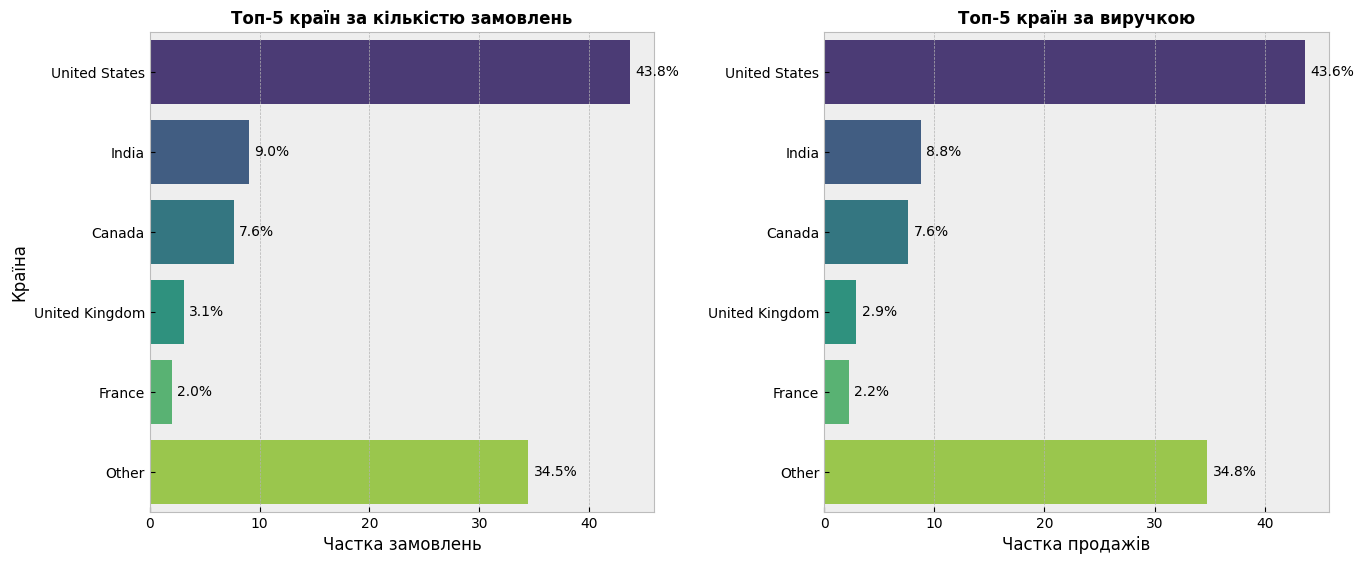

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

sns.barplot(data=top_orders_with_other, x='pct_from_total_orders', y='country', hue='country', ax=axes[0], palette='viridis')
axes[0].set_title('Топ-5 країн за кількістю замовлень', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Частка замовлень')
axes[0].set_ylabel('Країна')

for i, value in enumerate(top_orders_with_other['pct_from_total_orders']):
    axes[0].text(value + 0.5, i, f'{value:.1f}%', va='center')

sns.barplot(data=top_sales_with_other, x='pct_from_total_sales', y='country', hue='country', ax=axes[1], palette='viridis')
axes[1].set_title('Топ-5 країн за виручкою', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Частка продажів')
axes[1].set_ylabel('')

for i, value in enumerate(top_sales_with_other['pct_from_total_sales']):
    axes[1].text(value + 0.5, i, f'{value:.1f}%', va='center')

plt.tight_layout(pad=2.0)
plt.show()

Отже, можемо побачити переважаючу першість США у структурі продажів. Можемо зробити висновок, що ринок американського континенту переважно сегментований між двома країнами (США та Канада), в той час як Азія та Європа представлені багатьма державами.
Окрім цього, спотерігаємо схожі частки кількості замовлень та обсягу виручки, що означає відсутність суттєвої різниці між середніми обсягами замовлень.

Подивимось на середній обсяг замовлення більш детально.

In [ ]:
orders_and_sales = pd.merge(top_orders_with_other, top_sales_with_other, on='country', how='inner')

orders_and_sales['sales_per_order'] = (orders_and_sales['total_sales'] / orders_and_sales['orders']).round(2)

orders_and_sales.sort_values(by='sales_per_order', ascending=False, inplace=True)

orders_and_sales[['country', 'sales_per_order', 'pct_from_total_sales']].reset_index(drop=True)\
    .style\
    .set_caption('Середня ціна замовлення у розрізі країн')\
    .format({
        'sales_per_order': '{:.2f}',
        'pct_from_total_sales': '{:.2f}%'
    })

,country,sales_per_order,pct_from_total_sales
0,France,1048.22,2.22%
1,Other,962.18,34.76%
2,Canada,952.31,7.63%
3,United States,950.29,43.61%
4,India,927.62,8.79%
5,United Kingdom,911.87,2.93%


Середнє замовлення для більшості країн з топ 5 перебуває у діапазоні 911 - 952 дол. США. Дещо виділяється Франція з підвищеним рівнем середнього чеку, хоч і з невеликою долею загального ринку компанії. Цікаво відмітити різницю між територіально близькими ринками зі схожими долями - Францією та Великою Британією.

- Аналіз продажів у розрізі продуктів

In [ ]:
top_product_categories = df.groupby('category', observed=True)['price'].sum().reset_index(name='total_sales').sort_values(by='total_sales', ascending=False).reset_index(drop=True)
top_product_categories['pct_from_total_products'] = ((top_product_categories['total_sales'] / top_product_categories['total_sales'].sum()) * 100).round(2)
top_product_categories.style\
    .set_caption('Розподіл продажів за категоріями товарів')\
    .format({
        'total_sales': '{:.2f}',
        'pct_from_total_products': '{:.2f}%'
    })

,category,total_sales,pct_from_total_products
0,Sofas & armchairs,8388254.50,26.24%
1,Chairs,6147748.80,19.23%
2,Beds,4919725.00,15.39%
3,Bookcases & shelving units,3640818.10,11.39%
4,Cabinets & cupboards,2336499.50,7.31%
5,Outdoor furniture,2142222.20,6.70%
6,Tables & desks,1790307.50,5.60%
7,Chests of drawers & drawer units,906562.50,2.84%
8,Bar furniture,735503.00,2.30%
9,Children's furniture,467697.00,1.46%


In [ ]:
threshold = 3.0

major = top_product_categories[top_product_categories['pct_from_total_products'] >= threshold].copy()
minor = top_product_categories[top_product_categories['pct_from_total_products'] < threshold]

other_row = pd.DataFrame({
    'category': ['Other'],
    'total_sales': [minor['total_sales'].sum()],
    'pct_from_total_products': [minor['pct_from_total_products'].sum()]
})

top_product_grouped = pd.concat([major, other_row], ignore_index=True)

top_product_grouped = top_product_grouped.sort_values(by='total_sales', ascending=False).reset_index(drop=True)

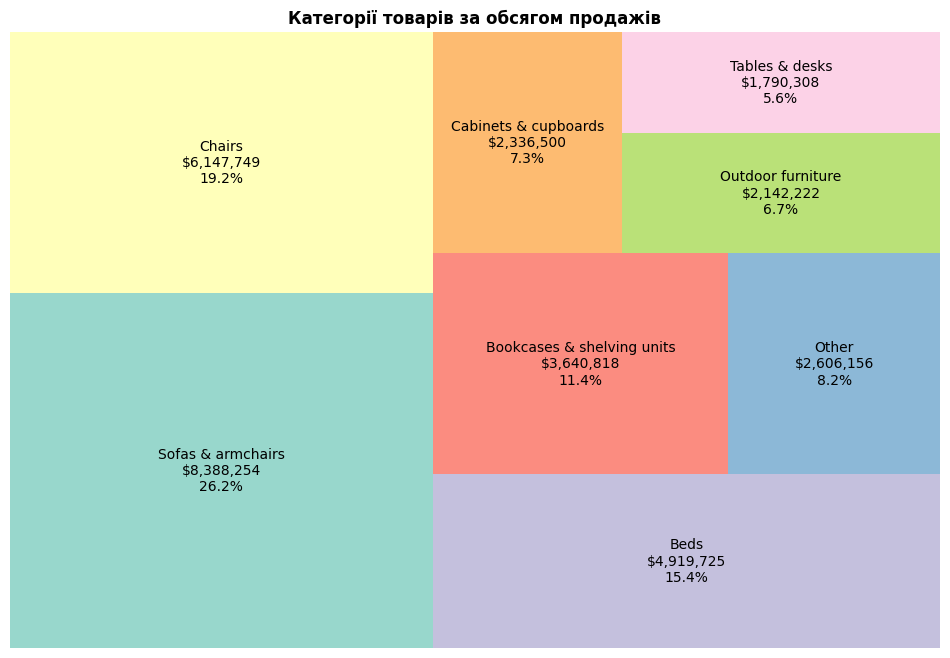

In [ ]:
colors = sns.color_palette("Set3", n_colors=len(top_product_grouped))
plt.figure(figsize=(12, 8))
squarify.plot(
    sizes=top_product_grouped['total_sales'],
    label=[
        f"{cat}\n${sales:,.0f}\n{pct:.1f}%"
        for cat, sales, pct in zip(
            top_product_grouped['category'],
            top_product_grouped['total_sales'],
            top_product_grouped['pct_from_total_products']
        )
    ],
    color=colors,
    alpha=0.9,
    text_kwargs={'fontsize': 10}
)
plt.axis('off')
plt.title("Категорії товарів за обсягом продажів", fontsize=12, fontweight='bold')
plt.show()

Топ 3 категорії - Sofas & armchairs, Chairs, Beds, на які припадає близько 60% продажів компанії.

Окрім цього, доцільно ознайомитись із середнім розміром замовлення.

In [ ]:
top_product_categories_avg = (
    df.groupby('category', observed=True)['price']
    .mean()
    .round(2)
    .reset_index(name='avg_price')
    .sort_values(by='avg_price', ascending=False)
    .reset_index(drop=True)
)

top_product_categories_avg_info = pd.merge(top_product_grouped, top_product_categories_avg, on='category')

top_product_categories_avg_info.style\
    .set_caption('Середня ціна замовлення у розрізі категорій товарів')\
    .format({
        'total_sales': '{:.2f}',
        'pct_from_total_products': '{:.2f}%',
        'avg_price': '{:.2f}'
    })

,category,total_sales,pct_from_total_products,avg_price
0,Sofas & armchairs,8388254.50,26.24%,1950.30
1,Chairs,6147748.80,19.23%,1032.89
2,Beds,4919725.00,15.39%,1681.38
3,Bookcases & shelving units,3640818.10,11.39%,477.17
4,Cabinets & cupboards,2336499.50,7.31%,1007.98
5,Outdoor furniture,2142222.20,6.70%,961.07
6,Tables & desks,1790307.50,5.60%,608.74


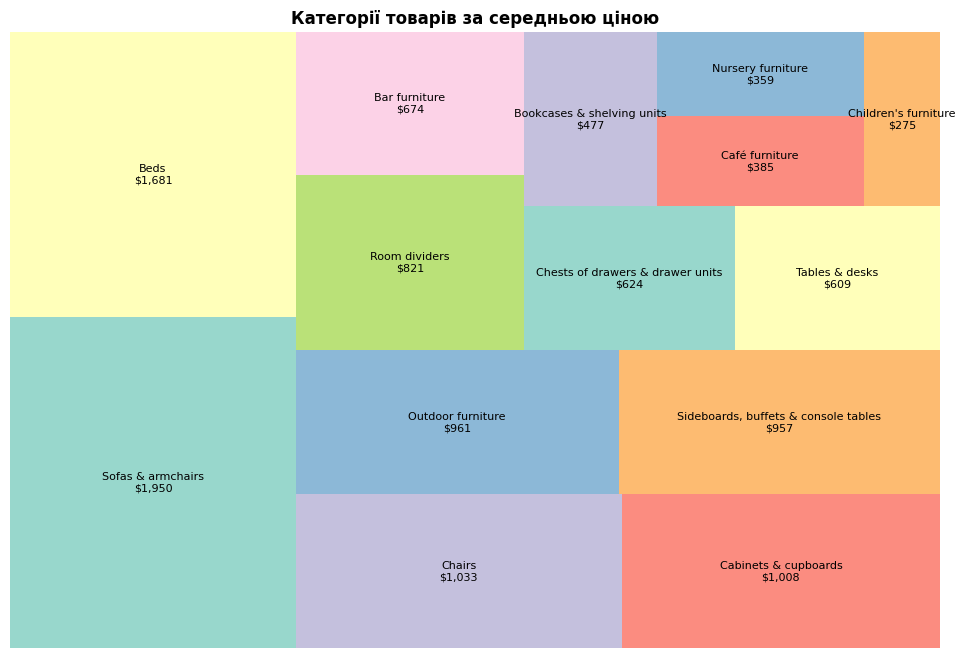

In [ ]:
colors = sns.color_palette("Set3", n_colors=len(top_product_grouped))
plt.figure(figsize=(12, 8))
squarify.plot(
    sizes=top_product_categories_avg['avg_price'],
    label=[
        f"{cat}\n${avg_price:,.0f}"
        for cat, avg_price in zip(
            top_product_categories_avg['category'],
            top_product_categories_avg['avg_price'],
        )
    ],
    color=colors,
    alpha=0.9,
    text_kwargs={'fontsize': 8}
)
plt.axis('off')
plt.title("Категорії товарів за середньою ціною", fontsize=12, fontweight='bold')
plt.show()

Бачимо, що Sofas & armchairs мають найбільший середній чек замовлення. Загалом у топі продажів представлені товари різноманітного цінового діапазону.

- Аналіз продажів у розрізі продуктів у різних країнах

Проведемо огляд структури продажів у країні з найбільшим ринком - США, а також порівняємо між собою структуру продажів у Франції та Великій Британії, по яким спостерігалася суттєва різниця по середньому замовленню.

In [ ]:
countries = ['United States', 'France', 'United Kingdom']

country_stats = {}

for country in countries:
    df_country = df[df['country'] == country]

    top_categories = (
        df_country.groupby('category', observed=True)['price']
        .sum()
        .reset_index(name='total_sales')
        .sort_values(by='total_sales', ascending=False)
        .reset_index(drop=True)
    )

    top_categories['pct_from_total_products'] = (
        top_categories['total_sales'] / top_categories['total_sales'].sum() * 100
    ).round(2)

    country_stats[country] = top_categories

In [ ]:
country_name = 'United States'
usa_vs_total = pd.merge(
    top_product_categories,
    country_stats['United States'],
    on='category',
    suffixes=('_global', f'_{country_name.lower()}')
)
usa_vs_total.rename(columns={'pct_from_total_products_united states': 'pct_usa'}, inplace=True)
usa_vs_total['dif'] = usa_vs_total['pct_from_total_products_global'] - usa_vs_total['pct_usa']
usa_vs_total[['category', 'pct_usa', 'dif']].style\
    .set_caption('Розподіл за категоріями товарів у США')\
    .format({
        'dif': '{:.2f}%',
        'pct_usa': '{:.2f}%',
    })


,category,pct_usa,dif
0,Sofas & armchairs,26.59%,-0.35%
1,Chairs,18.79%,0.44%
2,Beds,15.87%,-0.48%
3,Bookcases & shelving units,11.24%,0.15%
4,Cabinets & cupboards,7.13%,0.18%
5,Outdoor furniture,6.66%,0.04%
6,Tables & desks,5.58%,0.02%
7,Chests of drawers & drawer units,2.74%,0.10%
8,Bar furniture,2.37%,-0.07%
9,Children's furniture,1.49%,-0.03%


In [ ]:
country1 = 'France'
country2 = 'United Kingdom'

df_france_uk = pd.merge(
    country_stats[country1],
    country_stats[country2],
    on='category',
    how='outer',
    suffixes=(f'_{country1.lower().replace(" ", "_")}', f'_{country2.lower().replace(" ", "_")}')
)

df_france_uk = pd.merge(
    df_france_uk,
    top_product_categories_avg,
    on='category'
)

df_france_uk.rename(columns={'pct_from_total_products_france': 'pct_france', 'pct_from_total_products_united_kingdom': 'pct_uk'}, inplace=True)
df_france_uk['dif'] = df_france_uk['pct_france'] - df_france_uk['pct_uk']

df_france_uk[['category', 'pct_france', 'pct_uk', 'dif', 'avg_price']].sort_values(by='dif', ascending=False)\
    .style\
    .set_caption('Порівняння категорії проданих товарів у Великобританії та Франції')\
    .format({
        'avg_price': '{:.2f}',
        'dif': '{:.2f}%',
        'pct_france': '{:.2f}%',
        'pct_uk': '{:.2f}%'
    })


,category,pct_france,pct_uk,dif,avg_price
1,Beds,16.38%,14.26%,2.12%,1681.38
12,Sofas & armchairs,26.42%,25.02%,1.40%,1950.30
13,Tables & desks,5.95%,5.26%,0.69%,608.74
3,Cabinets & cupboards,8.32%,7.64%,0.68%,1007.98
7,Children's furniture,2.01%,1.42%,0.59%,274.79
8,Nursery furniture,0.70%,0.30%,0.40%,359.41
4,Café furniture,0.32%,0.49%,-0.17%,384.87
10,Room dividers,0.29%,0.58%,-0.29%,820.80
11,"Sideboards, buffets & console tables",0.07%,0.44%,-0.37%,957.05
9,Outdoor furniture,5.70%,6.07%,-0.37%,961.07


Як і очікувалось, у структурі продажів Франції переважають більш дорогі товари. Це може бути предметом подальшого дослідження - які причини такої різниці у структурах, чи відрізняються у цих країнах макретингові підходи тощо.
В цілому, не можна назвати таку різницю значною; загальне портфель вподобань покупців залишається досить схожим.

Розширимо даний аналіз до 5 країн.

In [ ]:
top_10_categories = (
    df.groupby('category', observed=True)['price']
    .sum()
    .nlargest(10)
    .index
)

top_5_countries = (
    df.groupby('country', observed=True)['price']
    .sum()
    .nlargest(5)
    .index
)

df_top_categories_countries = df[df['category'].isin(top_10_categories) & df['country'].isin(top_5_countries)].copy()
df_top_categories_countries['country'] = df_top_categories_countries['country'].cat.remove_unused_categories()
df_top_categories_countries['category'] = df_top_categories_countries['category'].cat.remove_unused_categories()

pivot = pd.pivot_table(
    df_top_categories_countries,
    values='price',
    index='country',
    columns='category',
    aggfunc='sum',
    fill_value=0,
    observed=False
)

pivot['Total'] = pivot.sum(axis=1)
pivot = pivot.sort_values(by='Total', ascending=False)

percent = pivot.div(pivot['Total'], axis=0) * 100
percent_formatted = percent.drop(columns='Total').round(1).astype(str) + '%'

pivot_str = pivot.drop(columns='Total').map(lambda x: f"{x:,.0f}")

combined = pivot_str.copy()
for col in pivot_str.columns:
    combined[col] = pivot_str[col] + ' (' + percent_formatted[col] + ')'

combined['Total'] = pivot['Total'].apply(lambda x: f"{x:,.0f}")

styled = combined.style.set_caption('Сума продажів за категоріями та країнами')

styled


category,Bar furniture,Beds,Bookcases & shelving units,Cabinets & cupboards,Chairs,Chests of drawers & drawer units,Children's furniture,Outdoor furniture,Sofas & armchairs,Tables & desks,Total
country,,,,,,,,,,,
United States,"330,805 (2.4%)","2,213,058 (16.1%)","1,567,607 (11.4%)","994,546 (7.2%)","2,619,774 (19.1%)","382,388 (2.8%)","207,575 (1.5%)","929,245 (6.8%)","3,707,144 (27.0%)","777,865 (5.7%)","13,730,007"
India,"57,657 (2.1%)","358,320 (13.0%)","364,507 (13.2%)","191,888 (6.9%)","544,309 (19.7%)","73,111 (2.6%)","39,177 (1.4%)","162,289 (5.9%)","788,430 (28.5%)","186,158 (6.7%)","2,765,846"
Canada,"51,724 (2.2%)","354,772 (14.8%)","278,982 (11.6%)","181,802 (7.6%)","417,741 (17.4%)","71,952 (3.0%)","30,264 (1.3%)","185,323 (7.7%)","692,428 (28.9%)","132,678 (5.5%)","2,397,665"
United Kingdom,"22,103 (2.4%)","133,816 (14.5%)","113,988 (12.4%)","71,684 (7.8%)","188,519 (20.5%)","36,784 (4.0%)","13,348 (1.4%)","57,002 (6.2%)","234,812 (25.5%)","49,374 (5.4%)","921,431"
France,"11,199 (1.6%)","116,414 (16.6%)","73,830 (10.5%)","59,102 (8.4%)","134,029 (19.1%)","21,544 (3.1%)","14,258 (2.0%)","40,486 (5.8%)","187,735 (26.8%)","42,299 (6.0%)","700,897"


Отже, спостерігаються точкові різниці між частками різних категорій товарів, але вони не є значними.

- Аналіз продажів у розрізі типів девайсу

In [ ]:
sales_by_device = (
    df.groupby(['device'], observed=True)['price']
    .agg(orders='count', total_sales='sum', avg_sales='mean')
    .reset_index()
    .sort_values(by='total_sales', ascending=False)
    .reset_index(drop=True)
)

sales_by_device['avg_sales'] = sales_by_device['avg_sales'].round(2)
sales_by_device['pct_orders'] = ((sales_by_device['orders'] / sales_by_device['orders'].sum()) * 100).round(2)
sales_by_device['pct_sales'] = ((sales_by_device['total_sales'] / sales_by_device['total_sales'].sum()) * 100).round(2)

sales_by_device.style\
    .set_caption('Розподіл продажів за типами девайсу')\
    .format({
        'total_sales': '{:.2f}',
        'avg_sales': '{:.2f}',
        'pct_orders': '{:.2f}%',
        'pct_sales': '{:.2f}%'
    })

,device,orders,total_sales,avg_sales,pct_orders,pct_sales
0,desktop,19702,18864039.00,957.47,58.75%,59.00%
1,mobile,13113,12384225.80,944.42,39.10%,38.73%
2,tablet,723,723466.30,1000.64,2.16%,2.26%


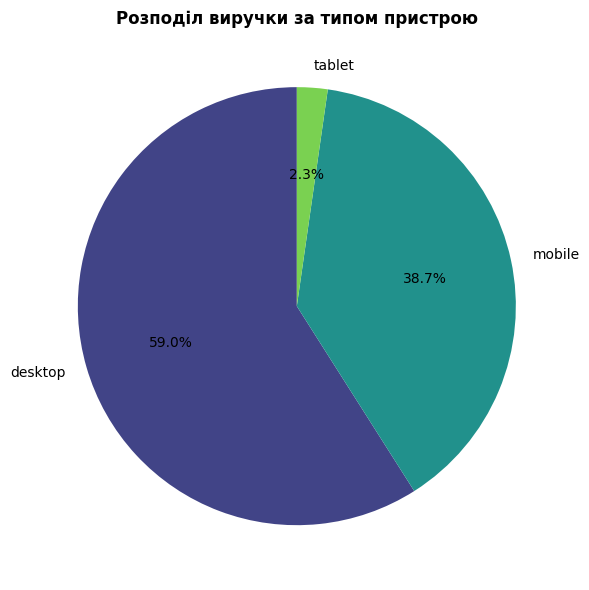

In [ ]:
plt.figure(figsize=(6, 6))
plt.pie(
    sales_by_device['pct_sales'],
    labels=sales_by_device['device'],
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.viridis([0.2, 0.5, 0.8])
)

plt.title('Розподіл виручки за типом пристрою', fontsize=12, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

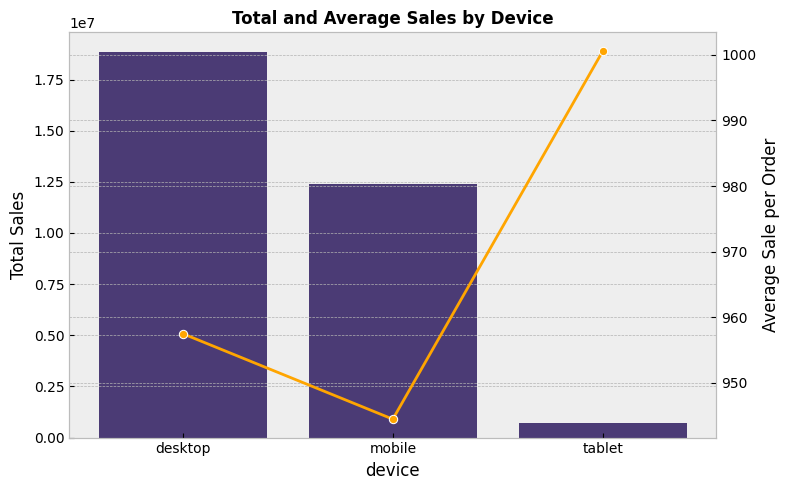

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 5))

sns.barplot(data=sales_by_device, x='device', y='total_sales', ax=ax1)
ax1.set_ylabel('Total Sales')

ax2 = ax1.twinx()
sns.lineplot(data=sales_by_device, x='device', y='avg_sales', ax=ax2, marker='o', color='orange', linewidth=2)
ax2.set_ylabel('Average Sale per Order')

plt.title('Total and Average Sales by Device', fontsize=12, fontweight='bold')
plt.xlabel('Device')
plt.tight_layout()
plt.show()

Бачимо, що основна частина продажів (близько 60%) припадає на продаж через персональні комп'ютери та ноутбуки, решта - майже повністю на мобільні пристрої. Продаж через планшети займає низький обсяг у структурі. Окрім цього, середня ціна замовлення також вища для десктопної версії.

Додатково виведемо продажі по моделям девайсів.

In [ ]:
sales_by_device_model = (
    df.groupby(['device', 'mobile_model_name'], observed=True)['price']
    .agg(orders='count', total_sales='sum', avg_sales='mean')
    .reset_index()
    .sort_values(by='total_sales', ascending=False)
    .reset_index(drop=True)
)

sales_by_device_model['avg_sales'] = sales_by_device_model['avg_sales'].round(2)
sales_by_device_model['pct_orders'] = ((sales_by_device_model['orders'] / sales_by_device_model['orders'].sum()) * 100).round(2)
sales_by_device_model['pct_sales'] = ((sales_by_device_model['total_sales'] / sales_by_device_model['total_sales'].sum()) * 100).round(2)

sales_by_device_model.style\
    .set_caption('Розподіл продажів у розрізі типів та моделей девайсів')\
    .format({
        'total_sales': '{:.2f}',
        'avg_sales': '{:.2f}',
        'pct_orders': '{:.2f}%',
        'pct_sales': '{:.2f}%'
    })

,device,mobile_model_name,orders,total_sales,avg_sales,pct_orders,pct_sales
0,desktop,Chrome,9359,8899523.90,950.91,27.91%,27.84%
1,desktop,Safari,6831,6490467.10,950.15,20.37%,20.30%
2,mobile,iPhone,6819,6420776.30,941.60,20.33%,20.08%
3,mobile,,6069,5735073.60,944.98,18.10%,17.94%
4,desktop,ChromeBook,1877,1830458.70,975.20,5.60%,5.73%
5,desktop,Edge,740,696877.30,941.73,2.21%,2.18%
6,desktop,,465,525645.10,1130.42,1.39%,1.64%
7,tablet,iPad,456,448854.20,984.33,1.36%,1.40%
8,desktop,Firefox,430,421066.90,979.23,1.28%,1.32%
9,tablet,,267,274612.10,1028.51,0.80%,0.86%


Основні девайси та моделі по кількості сесій показують середню 940-950 дол. США. Дещо виділяється ChromeBook, маючи суттєву кількість сесій і відносно високу величину середньої покупки у 975 дол. США.

Також окремо виведемо величини середніх покупок по девайсам та браузерам.

In [ ]:
pivot_avg_sales = pd.pivot_table(
    df,
    values='price',
    index='device',
    columns='browser',
    aggfunc=['mean', 'count'],
    fill_value=0,
    observed=False
).round(2)

pivot_avg_sales = pivot_avg_sales.rename(columns={'<Other>': 'Other'})

pivot_avg_sales.style\
    .set_caption("Середня сума продажів за типами девайсу та браузера")\
    .format({
        ('mean', 'Android Webview'): '{:.2f}',
        ('mean', 'Chrome'): '{:.2f}',
        ('mean', 'Edge'): '{:.2f}',
        ('mean', 'Firefox'): '{:.2f}',
        ('mean', 'Safari'): '{:.2f}',
        ('mean', 'Other'): '{:.2f}'
    })

Бачимо збільшення середнього рівня покупки для Firefox та Safari у десктопних версіях.

- Аналіз продажів у розрізі каналів залучення покупців

In [ ]:
sales_by_channel = (
    df.groupby(['channel'], observed=True)['price']
    .agg(orders='count', total_sales='sum', avg_sales='mean')
    .reset_index()
    .sort_values(by='total_sales', ascending=False)
    .reset_index(drop=True)
)

sales_by_channel['avg_sales'] = sales_by_channel['avg_sales'].round(2)
sales_by_channel['pct_orders'] = ((sales_by_channel['orders'] / sales_by_channel['orders'].sum()) * 100).round(2)
sales_by_channel['pct_sales'] = ((sales_by_channel['total_sales'] / sales_by_channel['total_sales'].sum()) * 100).round(2)

sales_by_channel.style\
    .set_caption('Розподіл продажів за каналами залучення покупців')\
    .format({
        'total_sales': '{:.2f}',
        'avg_sales': '{:.2f}',
        'pct_orders': '{:.2f}%',
        'pct_sales': '{:.2f}%'
    })

,channel,orders,total_sales,avg_sales,pct_orders,pct_sales
0,Organic Search,11921,11433151.60,959.08,35.54%,35.76%
1,Paid Search,9042,8511049.40,941.28,26.96%,26.62%
2,Direct,7800,7494923.40,960.89,23.26%,23.44%
3,Social Search,2716,2532105.70,932.29,8.10%,7.92%
4,Undefined,2059,2000501.00,971.59,6.14%,6.26%


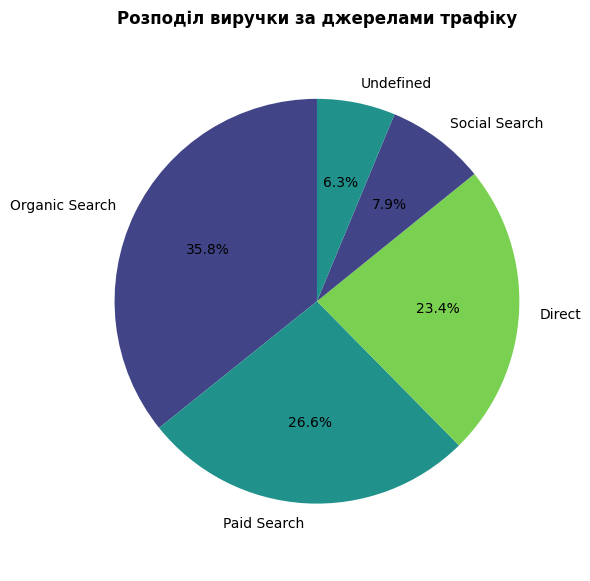

In [ ]:
plt.figure(figsize=(6, 6))
plt.pie(
    sales_by_channel['pct_sales'],
    labels=sales_by_channel['channel'],
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.viridis([0.2, 0.5, 0.8])
)

plt.title('Розподіл виручки за джерелами трафіку', fontsize=12, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

Бачимо, що більшість покупців (35.8%) були залучені через Organic Search, що може свідчити про ефективність SEO оптимізації. Рівень Paid Search (26.6%) може стати предметом аналізу ефективності маркетингових кампаній, а Direct (23.4%) свідчить про наявність певної клієнтської бази у даного бізнесу.

Також проаналізуємо розподіл залучених користувачів у розрізі девайсів, пам'ятаючи про різницю між середніми чеками (десктоп близько 957 дол. США, мобільні девайси - близько 944 долю США).

In [ ]:
pivot = pd.pivot_table(
    df,
    values='ga_session_id',
    index='device',
    columns='channel',
    aggfunc='count',
    fill_value=0,
    observed=False
)

pivot['Total'] = pivot.sum(axis=1)

percent = pivot.div(pivot['Total'], axis=0) * 100
percent = percent.drop(columns='Total')

percent_formatted = percent.round(1).astype(str) + '%'

pivot.loc['Total'] = pivot.sum()
percent_formatted.loc['Total'] = ''

pivot_str = pivot.drop(columns='Total').astype(int).astype(str)

total_row_mask = pivot_str.index == 'Total'

combined = pivot_str.copy()
for col in pivot_str.columns:
    combined[col] = np.where(
        total_row_mask,
        pivot_str[col],
        pivot_str[col] + ' (' + percent_formatted[col] + ')'
    )

combined['Total'] = pivot['Total'].astype(int).astype(str)

combined.style.set_caption('Кількість сесій у розрізі каналів трафіку та девайсів')

channel,Direct,Organic Search,Paid Search,Social Search,Undefined,Total
device,,,,,,
desktop,4655 (23.6%),7011 (35.6%),5261 (26.7%),1594 (8.1%),1181 (6.0%),19702
mobile,2985 (22.8%),4655 (35.5%),3574 (27.3%),1065 (8.1%),834 (6.4%),13113
tablet,160 (22.1%),255 (35.3%),207 (28.6%),57 (7.9%),44 (6.1%),723
Total,7800,11921,9042,2716,2059,33538


Загалом, відсутні суттєві нерівномірності у співвідношеннях.

In [ ]:
sessions_by_continent_channel = (
    df.groupby(['continent', 'channel'], observed=True)['ga_session_id']
    .count()
    .reset_index(name='session_count')
)

sales_by_continent_channel = (
    df.groupby(['continent', 'channel'], observed=True)['price']
    .sum()
    .reset_index(name='total_sales')
)

continent_channel_stats = pd.merge(
    sessions_by_continent_channel,
    sales_by_continent_channel,
    on=['continent', 'channel'],
    how='outer'
)

totals = continent_channel_stats.groupby('continent', observed=True)[['session_count', 'total_sales']].sum().rename(
    columns={'session_count': 'total_sessions', 'total_sales': 'total_sales_sum'}
)

continent_channel_stats = continent_channel_stats.merge(
    totals, on='continent'
)

continent_channel_stats['pct_sessions'] = (continent_channel_stats['session_count'] / continent_channel_stats['total_sessions'] * 100).round(2)
continent_channel_stats['pct_sales'] = (continent_channel_stats['total_sales'] / continent_channel_stats['total_sales_sum'] * 100).round(2)

continent_channel_stats = continent_channel_stats[
    ['continent', 'channel', 'session_count', 'total_sales', 'pct_sessions', 'pct_sales']
].sort_values(by=['continent', 'session_count'], ascending=[True, False])

continent_channel_stats.style\
    .set_caption('Розподіл сесій та продажів по континентам та каналам залучення покупців')\
    .format({
        'total_sales': '{:.2f}',
        'pct_sessions': '{:.2f}%',
        'pct_sales': '{:.2f}%'
    })

,continent,channel,session_count,total_sales,pct_sessions,pct_sales
2,(not set),Paid Search,21,19931.00,29.58%,26.91%
1,(not set),Organic Search,20,15080.00,28.17%,20.36%
0,(not set),Direct,16,21443.00,22.54%,28.95%
3,(not set),Social Search,10,11224.40,14.08%,15.15%
4,(not set),Undefined,4,6389.00,5.63%,8.63%
6,Africa,Organic Search,131,129908.40,38.64%,39.22%
7,Africa,Paid Search,89,88195.00,26.25%,26.63%
5,Africa,Direct,70,70028.00,20.65%,21.14%
8,Africa,Social Search,31,31187.60,9.14%,9.42%
9,Africa,Undefined,18,11912.00,5.31%,3.60%


Загалом, спостерігаємо приблизно однакові співвідношення по каналам залучення покупців на ключових ринках компанії.

Пам'ятаючи про раніше виявлену різницю між середнім чеком у Франції та Великій Британії, розглянемо розподіл продажів у розрізі каналів залучення покупців у цих країнах.

In [ ]:
df_france = df[df['country'] == 'France']

sales_by_channel_fr = (
    df_france.groupby(['country', 'channel'], observed=True)['price']
    .agg(orders='count', total_sales='sum')
    .reset_index()
)

sales_by_channel_fr['pct_orders'] = ((sales_by_channel_fr['orders'] / sales_by_channel_fr['orders'].sum()) * 100).round(2)
sales_by_channel_fr['pct_sales'] = ((sales_by_channel_fr['total_sales'] / sales_by_channel_fr['total_sales'].sum()) * 100).round(2)
sales_by_channel_fr.sort_values(by='pct_sales', ascending=False, inplace=True)
sales_by_channel_fr.reset_index(drop=True, inplace=True)

sales_by_channel_fr.style\
    .set_caption('Розподіл покупців за каналами залучення у Франції')\
    .format({
        'total_sales': '{:.2f}',
        'pct_orders': '{:.2f}%',
        'pct_sales': '{:.2f}%'
    })

,country,channel,orders,total_sales,pct_orders,pct_sales
0,France,Organic Search,247,261008.60,36.43%,36.73%
1,France,Paid Search,191,192421.30,28.17%,27.08%
2,France,Direct,156,169299.50,23.01%,23.82%
3,France,Social Search,45,46713.40,6.64%,6.57%
4,France,Undefined,39,41250.00,5.75%,5.80%


In [ ]:
df_uk = df[df['country'] == 'United Kingdom']

sales_by_channel_uk = (
    df_uk.groupby(['country', 'channel'], observed=True)['price']
    .agg(orders='count', total_sales='sum')
    .reset_index()
)

sales_by_channel_uk['pct_orders'] = ((sales_by_channel_uk['orders'] / sales_by_channel_uk['orders'].sum()) * 100).round(2)
sales_by_channel_uk['pct_sales'] = ((sales_by_channel_uk['total_sales'] / sales_by_channel_uk['total_sales'].sum()) * 100).round(2)
sales_by_channel_uk.sort_values(by='pct_sales', ascending=False, inplace=True)
sales_by_channel_uk.reset_index(drop=True, inplace=True)

sales_by_channel_uk.style\
    .set_caption('Розподіл покупців за каналами залучення у Великобританії')\
    .format({
        'total_sales': '{:.2f}',
        'pct_orders': '{:.2f}%',
        'pct_sales': '{:.2f}%'
    })

,country,channel,orders,total_sales,pct_orders,pct_sales
0,United Kingdom,Organic Search,379,356438.90,36.83%,37.99%
1,United Kingdom,Paid Search,289,278652.60,28.09%,29.70%
2,United Kingdom,Direct,236,203728.90,22.93%,21.71%
3,United Kingdom,Social Search,73,51836.00,7.09%,5.52%
4,United Kingdom,Undefined,52,47661.50,5.05%,5.08%


In [ ]:
merged_channels_fr_uk = pd.merge(
    sales_by_channel_fr,
    sales_by_channel_uk,
    on='channel',
    suffixes=('_france', '_uk')
)

merged_channels_fr_uk['dif'] = merged_channels_fr_uk['pct_sales_france'] - merged_channels_fr_uk['pct_sales_uk']

merged_channels_fr_uk[['channel', 'pct_sales_france', 'pct_sales_uk', 'dif']].style\
    .set_caption('Порівняння каналів залучення покупців у Франції та Великобританії')\
    .format({
        'pct_sales_france': '{:.2f}%',
        'pct_sales_uk': '{:.2f}%',
        'dif': '{:.2f}%'
    })

,channel,pct_sales_france,pct_sales_uk,dif
0,Organic Search,36.73%,37.99%,-1.26%
1,Paid Search,27.08%,29.70%,-2.62%
2,Direct,23.82%,21.71%,2.11%
3,Social Search,6.57%,5.52%,1.05%
4,Undefined,5.80%,5.08%,0.72%


Суттєвих розбіжностей у каналах не спостерігається, але різниця між Direct у деякій мірі може свідчити про наявність більшої бази покупців у Франції, що і може забезпечувати різницю між розміром середньої покупки.

- Аналіз зареєстрованих користувачів

Поглянемо на співвідношення зареєстрованих та незареєстрованих користувачів на прикладі поля is_verified (поле показує підтвердження електронної пошти після реєстрації).

In [ ]:
df['is_verified'].value_counts(normalize=True)

,proportion
is_verified,
not_registered,0.917079
1,0.059306
0,0.023615


Бачимо, що більшість користувачів не є зареєстрованими, що в принципі може бути логічним, оскільки меблі є відносно нерегулярними покупками. Таком можливо, що компанія тільки почала розвивати цей напрям.

In [ ]:
register_map = {
    'not_registered': 'not_registered',
    0: 'registered',
    1: 'registered',
}

df['has_account'] = df['is_verified'].map(register_map)

print(df['has_account'].value_counts())

has_account
not_registered    30757
registered         2781
Name: count, dtype: int64


In [ ]:
sales_by_registration = (
    df.groupby(['has_account'], observed=True)['price']
    .agg(orders='count', total_sales='sum', avg_sales='mean')
    .reset_index()
    .sort_values(by='total_sales', ascending=False)
    .reset_index(drop=True)
)

sales_by_registration['avg_sales'] = sales_by_registration['avg_sales'].round(2)
sales_by_registration['pct_orders'] = ((sales_by_registration['orders'] / sales_by_registration['orders'].sum()) * 100).round(2)
sales_by_registration['pct_sales'] = ((sales_by_registration['total_sales'] / sales_by_registration['total_sales'].sum()) * 100).round(2)

sales_by_registration.style\
    .set_caption('Порівняння зареєстрованих та незареєстрованих користувачів')\
    .format({
        'total_sales': '{:,.2f}',
        'avg_sales': '{:,.2f}',
        'pct_orders': '{:.2f}%',
        'pct_sales': '{:.2f}%'
    })

,has_account,orders,total_sales,avg_sales,pct_orders,pct_sales
0,not_registered,30757,"29,389,212.60",955.53,91.71%,91.92%
1,registered,2781,"2,582,518.50",928.63,8.29%,8.08%


Попередній аналіз показує, що статус зареєстрованого користувача не виражається у величині середнього замовлення. Оскільки реєстрація користувача - це частина вибудови довгострокової взаємодії з ним, загальні переваги такої стратегії взаємодії не будуть видними у цьому 3-місячному датасеті.

In [ ]:
df_registered = df[df['has_account'] == 'registered']

registered_by_countries = (
    df_registered.groupby(['country'], observed=True)['price']
    .agg(orders='count')
    .reset_index()
    .sort_values(by='orders', ascending=False)
    .reset_index(drop=True)
)

registered_by_countries['pct_orders'] = ((registered_by_countries['orders'] / registered_by_countries['orders'].sum()) * 100).round(2)

registered_by_countries.style\
      .set_caption('Замовлення у розрізі країн для зареєстрованих користувачів')\
      .format({
        'pct_orders': '{:.2f}%',
    })


,country,orders,pct_orders
0,United States,1207,43.40%
1,India,246,8.85%
2,Canada,207,7.44%
3,United Kingdom,88,3.16%
4,France,56,2.01%
5,Germany,56,2.01%
6,Taiwan,51,1.83%
7,Spain,48,1.73%
8,China,48,1.73%
9,Singapore,44,1.58%


В цілому, структура розподілу по зареєстрованим користувачам  у розрізі країн співпадає із загальною структурою по клієнтам і продажам.

In [ ]:
accounts_by_verif = (
    df_registered.groupby(['is_verified'], observed=True)['price']
    .agg(orders='count', total_sales='sum', avg_sales='mean')
    .reset_index()
    .sort_values(by='orders', ascending=False)
    .reset_index(drop=True)
)

accounts_by_verif['avg_sales'] = accounts_by_verif['avg_sales'].round(2)
accounts_by_verif['pct_orders'] = ((accounts_by_verif['orders'] / accounts_by_verif['orders'].sum()) * 100).round(2)
accounts_by_verif['pct_sales'] = ((accounts_by_verif['total_sales'] / accounts_by_verif['total_sales'].sum()) * 100).round(2)

accounts_by_verif.style\
      .set_caption('Порівняння аккаунтів за статусом підтвердження електронної адреси')\
      .format({
        'total_sales': '{:,.2f}',
        'avg_sales': '{:,.2f}',
        'pct_orders': '{:.2f}%',
        'pct_sales': '{:.2f}%'
          })

,is_verified,orders,total_sales,avg_sales,pct_orders,pct_sales
0,1,1989,"1,866,017.40",938.17,71.52%,72.26%
1,0,792,"716,501.10",904.67,28.48%,27.74%


Спостерігаємо, що більшість користувачів підтверджує електронну адресу та в цілому має підвищений рівень середньої покупки.

In [ ]:
accounts_by_sub = (
    df_registered.groupby(['is_unsubscribed'], observed=True)['price']
    .agg(orders='count', total_sales='sum', avg_sales='mean')
    .reset_index()
    .sort_values(by='orders', ascending=False)
    .reset_index(drop=True)
)

accounts_by_sub['avg_sales'] = accounts_by_sub['avg_sales'].round(2)
accounts_by_sub['pct_orders'] = ((accounts_by_sub['orders'] / accounts_by_sub['orders'].sum()) * 100).round(2)
accounts_by_sub['pct_sales'] = ((accounts_by_sub['total_sales'] / accounts_by_sub['total_sales'].sum()) * 100).round(2)

accounts_by_sub.style\
      .set_caption('Порівняння аккаунтів за підпискою')\
      .format({
        'total_sales': '{:,.2f}',
        'avg_sales': '{:,.2f}',
        'pct_orders': '{:.2f}%',
        'pct_sales': '{:.2f}%'
          })

,is_unsubscribed,orders,total_sales,avg_sales,pct_orders,pct_sales
0,0,2334,"2,150,796.90",921.51,83.93%,83.28%
1,1,447,"431,721.60",965.82,16.07%,16.72%


Можемо побачити, що деяка частина користувачів (16.72%) відписалася від розсилки, що може свідчити про меншу вірогідність майбутніх покупок, однак поточний рівень середньої покупки у них вищий.

- Аналіз динаміки продажів

Загалом, датасет охоплює 3-місячний період. З урахуванням цього, спробуємо проаналізувати динаміку по дням, тижням та місяцям, а також окремо по дням тижня.

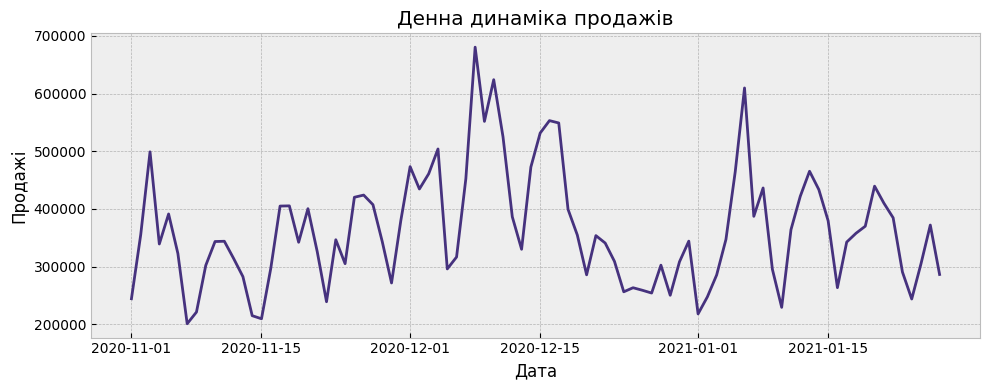

In [ ]:
df['day'] = df['date'].dt.date

daily_sales = df.groupby(df['day'])['price'].sum().reset_index()

plt.figure(figsize=(10, 4))
sns.lineplot(data=daily_sales, x='day', y='price')
plt.title('Денна динаміка продажів')
plt.xlabel('Дата')
plt.ylabel('Продажі')
plt.tight_layout()
plt.show()

На графіку помітні амплітуди, що свідчить про наявність циклічності між днями тижня.

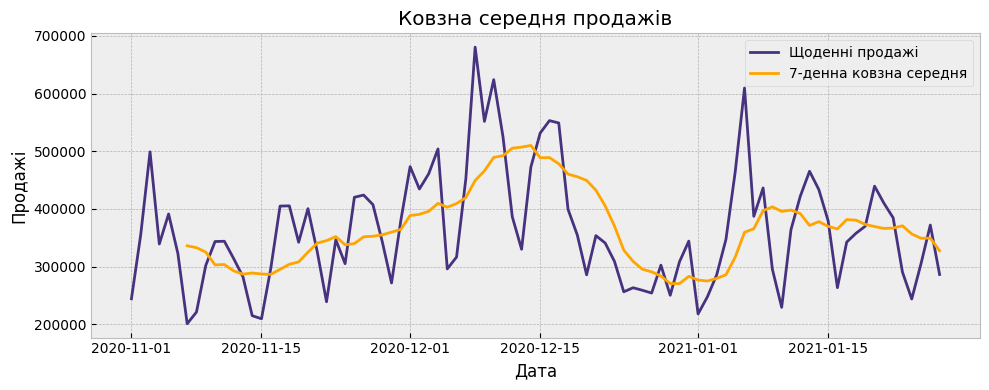

In [ ]:
df_daily = df.groupby('day')['price'].sum().reset_index().sort_values('day')
df_daily['rolling_7d'] = df_daily['price'].rolling(window=7).mean()

plt.figure(figsize=(10, 4))
sns.lineplot(data=df_daily, x='day', y='price', label='Щоденні продажі')
sns.lineplot(data=df_daily, x='day', y='rolling_7d', label='7-денна ковзна середня', color='orange')
plt.title('Ковзна середня продажів')
plt.xlabel('Дата')
plt.ylabel('Продажі')
plt.legend()
plt.tight_layout()
plt.show()

Тижнева ковзна середня природньо є більш згладженою. Вже по цьому графіку видне поступове збільшення продажів з листопада і особливо у першій половині грудня. Далі, вірогідно по причині святкового періоду, спостерігається зниження продажів та їх поступове відновлення у січні.

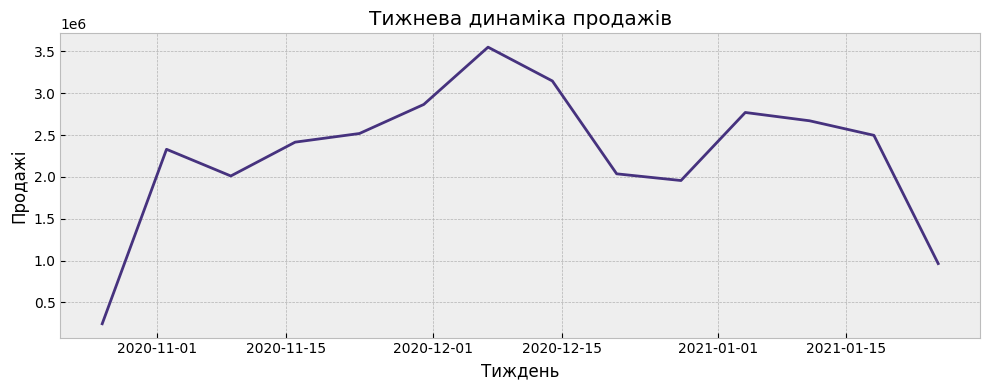

In [ ]:
df['week'] = df['date'].dt.to_period('W').dt.start_time

weekly_sales = df.groupby('week')['price'].sum().reset_index()

plt.figure(figsize=(10, 4))
sns.lineplot(data=weekly_sales, x='week', y='price')
plt.title('Тижнева динаміка продажів')
plt.xlabel('Тиждень')
plt.ylabel('Продажі')

plt.tight_layout()
plt.show()

Тижнева динаміка підтверджують раніше відмічене спостереження щодо підвищення продажів у першій половині грудня.

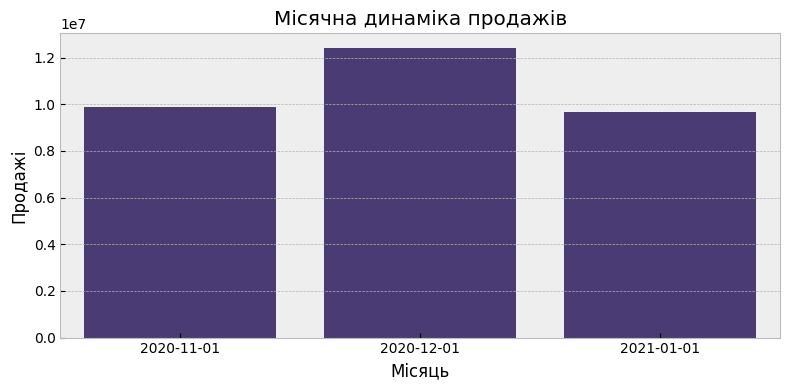

In [ ]:
df['month'] = df['date'].dt.to_period('M').dt.start_time

monthly_sales = df.groupby('month')['price'].sum().reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(data=monthly_sales, x='month', y='price')
plt.title('Місячна динаміка продажів')
plt.xlabel('Місяць')
plt.ylabel('Продажі')

plt.tight_layout()
plt.show()

Загалом, передсвяткове підвищення продажів зробило грудень більш успішним місяцем відносно листопада та січня.

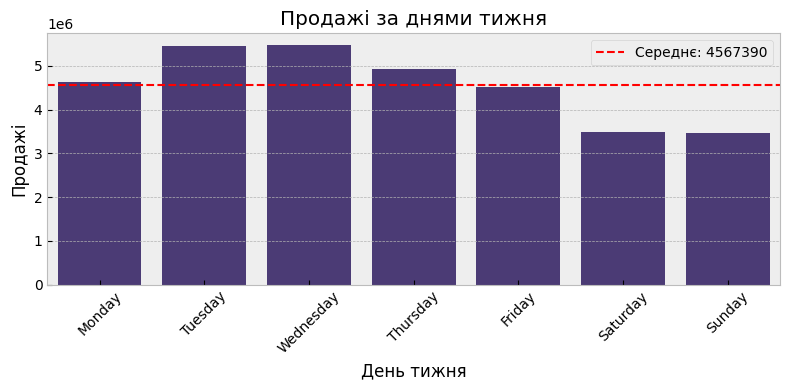

In [ ]:
df['weekday'] = df['date'].dt.day_name()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

weekday_sales = df.groupby('weekday', observed=True)['price'].sum().reindex(weekday_order).reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(data=weekday_sales, x='weekday', y='price')
plt.title('Продажі за днями тижня')
plt.xlabel('День тижня')
plt.ylabel('Продажі')
plt.xticks(rotation=45)

weekly_average = weekday_sales['price'].mean()
plt.axhline(weekly_average, color='red', linestyle='--', linewidth=1.5, label=f'Середнє: {weekly_average:.0f}')
plt.legend()

plt.tight_layout()

plt.show()

На графіку можемо побачити найбільш навантажені з точки зору замовлень дні тижня - вівторок, середа та четвер, а також спад замовлень на вихідних. Дана інформація може бути корисною при формуванні запасів та процесу відправки товарів.

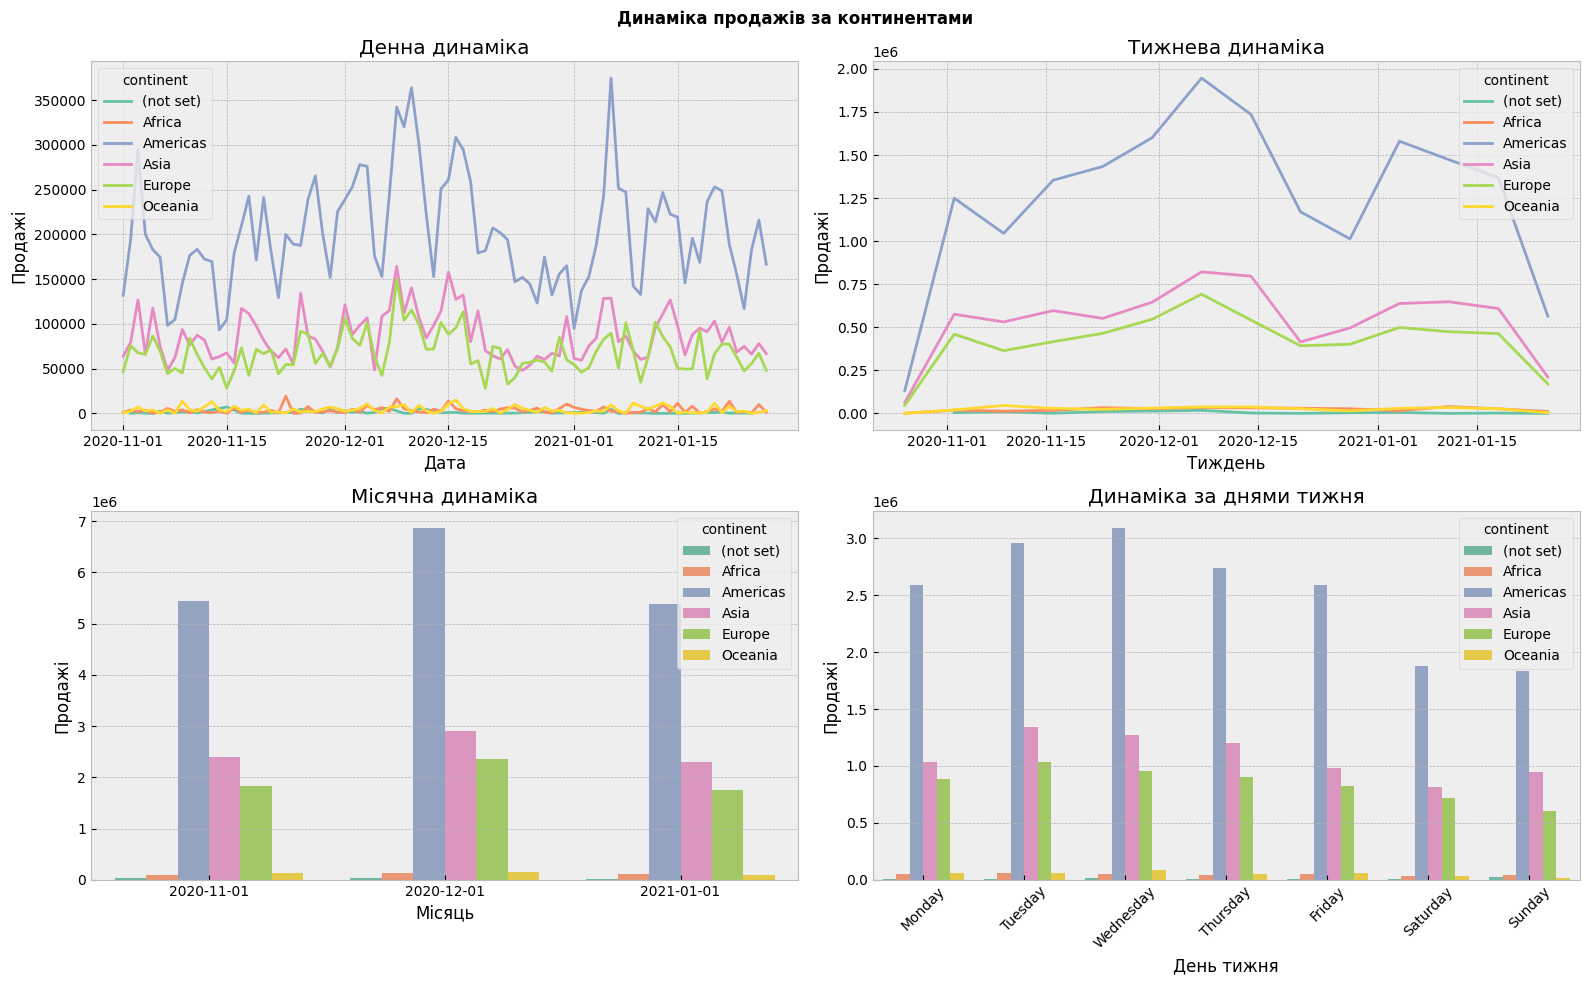

In [ ]:
palette = 'Set2'

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
fig.suptitle('Динаміка продажів за континентами', fontsize=12, fontweight='bold')

daily = df.groupby(['day', 'continent'], observed=True)['price'].sum().reset_index()
sns.lineplot(data=daily, x='day', y='price', hue='continent', ax=axes[0, 0], palette=palette)
axes[0, 0].set_title('Денна динаміка')
axes[0, 0].set_xlabel('Дата')
axes[0, 0].set_ylabel('Продажі')

weekly = df.groupby(['week', 'continent'], observed=True)['price'].sum().reset_index()
sns.lineplot(data=weekly, x='week', y='price', hue='continent', ax=axes[0, 1], palette=palette)
axes[0, 1].set_title('Тижнева динаміка')
axes[0, 1].set_xlabel('Тиждень')
axes[0, 1].set_ylabel('Продажі')

monthly = df.groupby(['month', 'continent'], observed=True)['price'].sum().reset_index()
sns.barplot(data=monthly, x='month', y='price', hue='continent', ax=axes[1, 0], palette=palette)
axes[1, 0].set_title('Місячна динаміка')
axes[1, 0].set_xlabel('Місяць')
axes[1, 0].set_ylabel('Продажі')

weekday = df.groupby(['weekday', 'continent'], observed=True)['price'].sum().reset_index()
weekday['weekday'] = pd.Categorical(weekday['weekday'], categories=weekday_order, ordered=True)
weekday = weekday.sort_values('weekday')
sns.barplot(data=weekday, x='weekday', y='price', hue='continent', ax=axes[1, 1], palette=palette)
axes[1, 1].set_title('Динаміка за днями тижня')
axes[1, 1].set_xlabel('День тижня')
axes[1, 1].set_ylabel('Продажі')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

На графіку динаміки продажів за континентами можемо побачити схожі тенденції для найбільших ринків компанії. Із денного графіку видно, що продажі на американському континенті є дещо більш волатильними. Також є невелика різниця у найбільш навантаженому продажами дні - для Америки це середа, а для Європи з Азією - вівторок. Також можна відмітити більшу рівномірність розподілу по дням для Європи порівняно з двома іншими великими ринками.

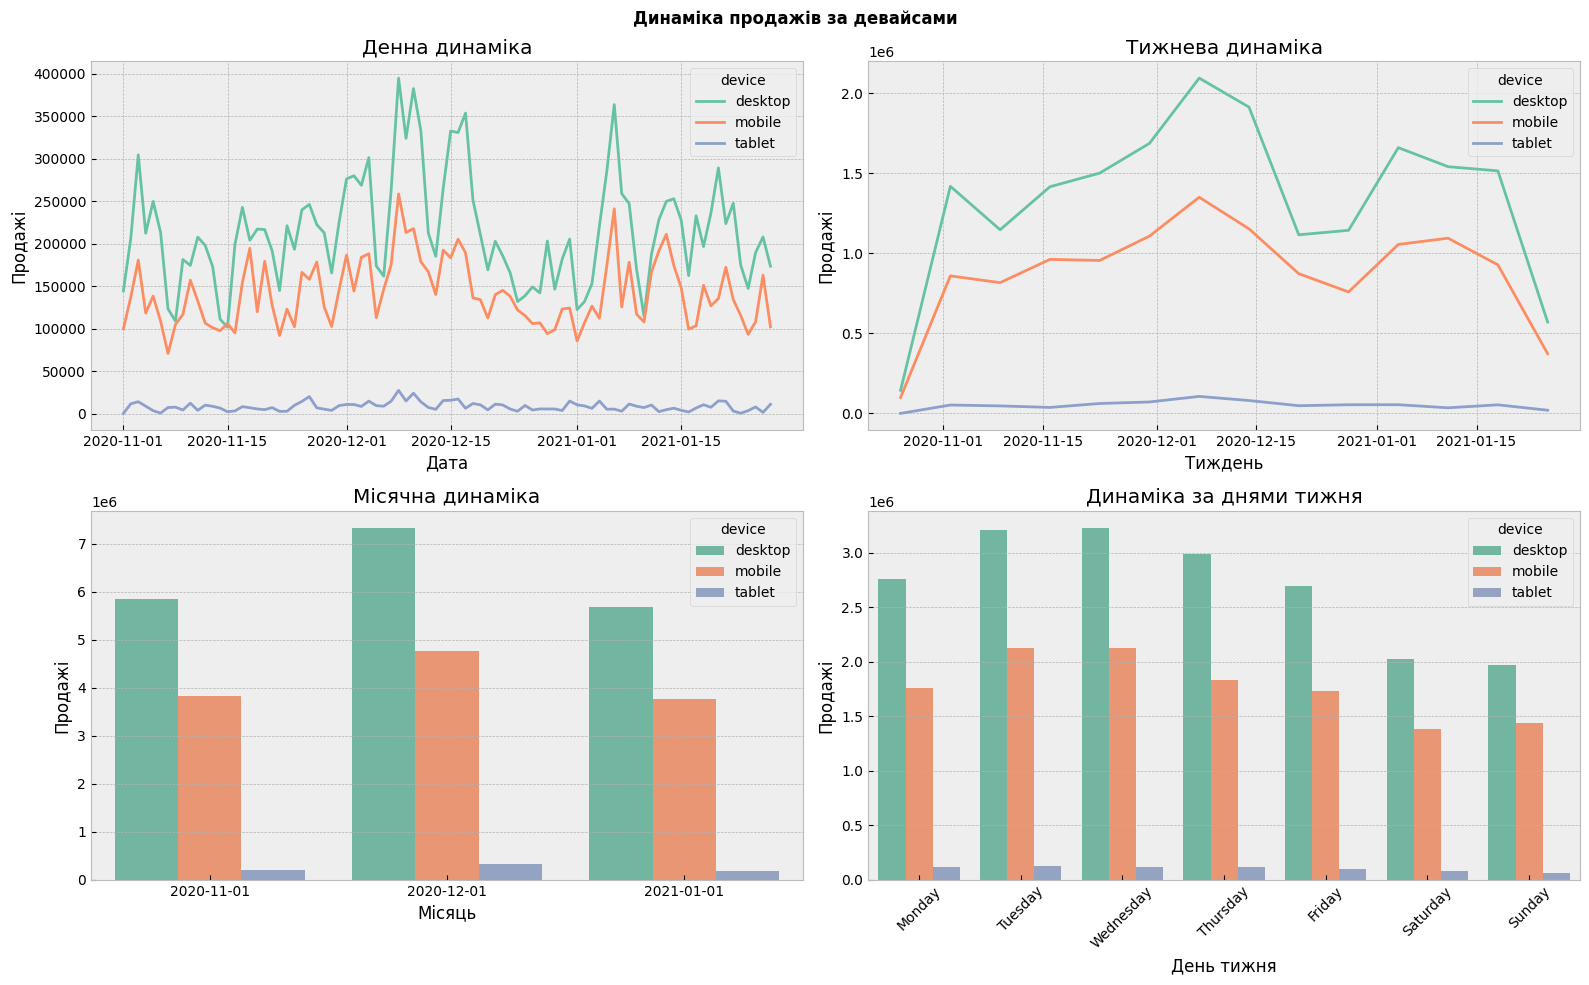

In [ ]:
palette = 'Set2'

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
fig.suptitle('Динаміка продажів за девайсами', fontsize=12, fontweight='bold')

daily = df.groupby(['day', 'device'], observed=True)['price'].sum().reset_index()
sns.lineplot(data=daily, x='day', y='price', hue='device', ax=axes[0, 0], palette=palette)
axes[0, 0].set_title('Денна динаміка')
axes[0, 0].set_xlabel('Дата')
axes[0, 0].set_ylabel('Продажі')

weekly = df.groupby(['week', 'device'], observed=True)['price'].sum().reset_index()
sns.lineplot(data=weekly, x='week', y='price', hue='device', ax=axes[0, 1], palette=palette)
axes[0, 1].set_title('Тижнева динаміка')
axes[0, 1].set_xlabel('Тиждень')
axes[0, 1].set_ylabel('Продажі')

monthly = df.groupby(['month', 'device'], observed=True)['price'].sum().reset_index()
sns.barplot(data=monthly, x='month', y='price', hue='device', ax=axes[1, 0], palette=palette)
axes[1, 0].set_title('Місячна динаміка')
axes[1, 0].set_xlabel('Місяць')
axes[1, 0].set_ylabel('Продажі')

weekday = df.groupby(['weekday', 'device'], observed=True)['price'].sum().reset_index()
weekday['weekday'] = pd.Categorical(weekday['weekday'], categories=weekday_order, ordered=True)
weekday = weekday.sort_values('weekday')
sns.barplot(data=weekday, x='weekday', y='price', hue='device', ax=axes[1, 1], palette=palette)
axes[1, 1].set_title('Динаміка за днями тижня')
axes[1, 1].set_xlabel('День тижня')
axes[1, 1].set_ylabel('Продажі')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Основні девайси показують схожу динаміку. Можна відмітити деяке зменшення у різниці між використанням ПК/ноутбуків та мобільних пристроїв у суботу та неділю.

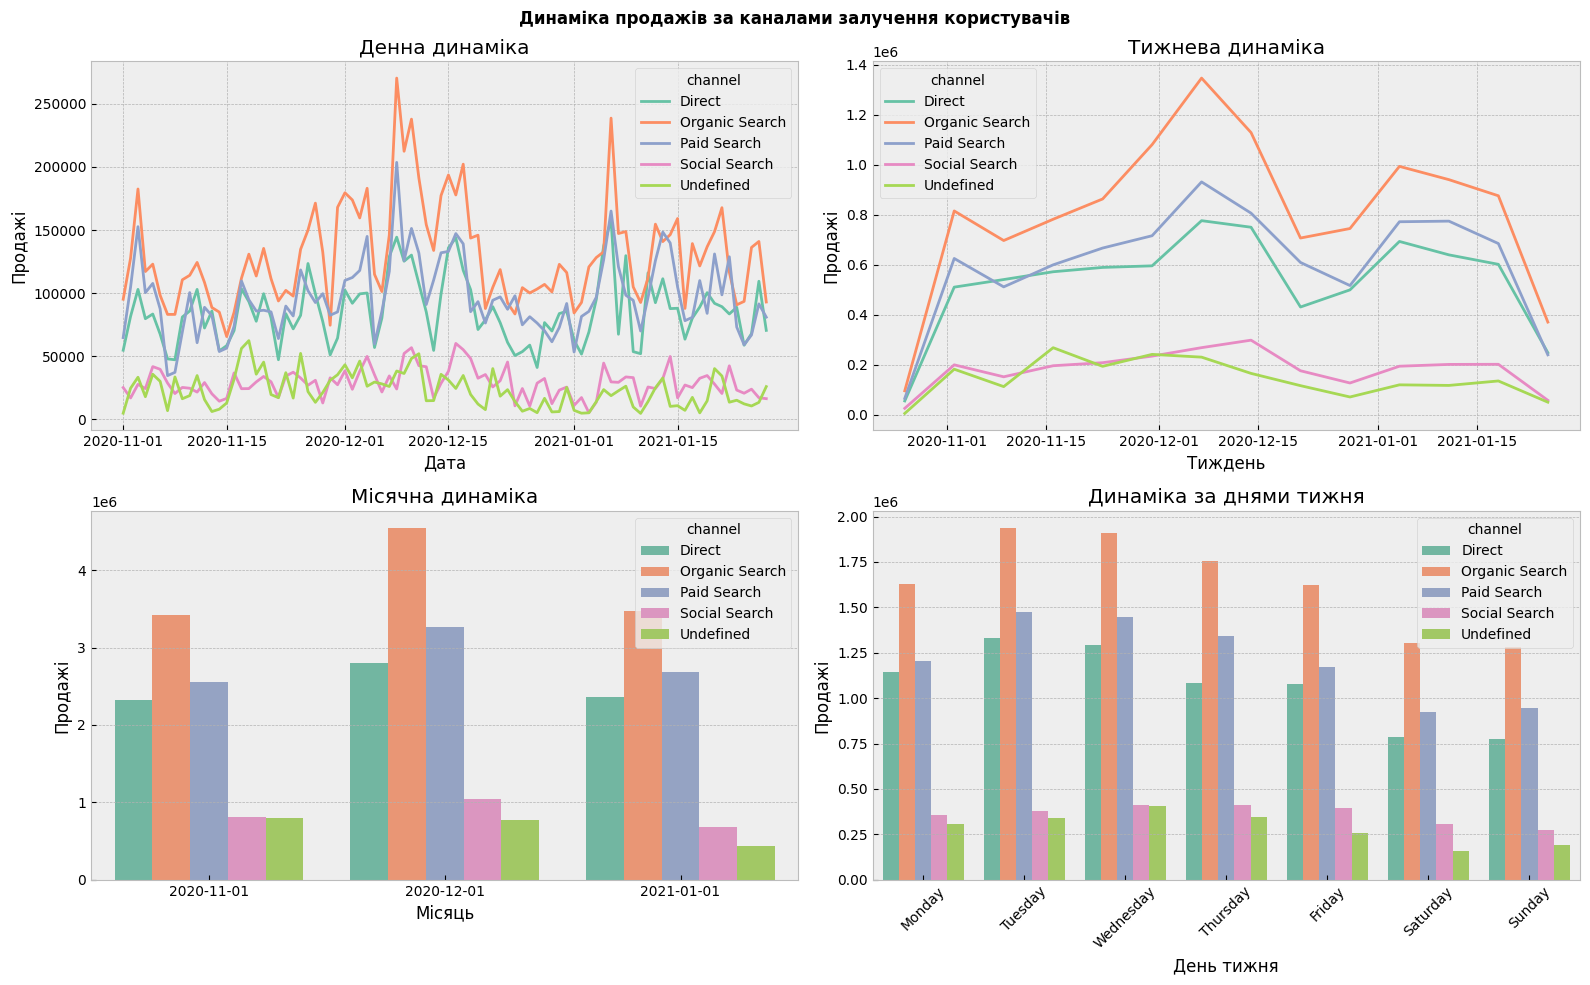

In [ ]:
palette = 'Set2'

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
fig.suptitle('Динаміка продажів за каналами залучення користувачів', fontsize=12, fontweight='bold')

daily = df.groupby(['day', 'channel'], observed=True)['price'].sum().reset_index()
sns.lineplot(data=daily, x='day', y='price', hue='channel', ax=axes[0, 0], palette=palette)
axes[0, 0].set_title('Денна динаміка')
axes[0, 0].set_xlabel('Дата')
axes[0, 0].set_ylabel('Продажі')

weekly = df.groupby(['week', 'channel'], observed=True)['price'].sum().reset_index()
sns.lineplot(data=weekly, x='week', y='price', hue='channel', ax=axes[0, 1], palette=palette)
axes[0, 1].set_title('Тижнева динаміка')
axes[0, 1].set_xlabel('Тиждень')
axes[0, 1].set_ylabel('Продажі')

monthly = df.groupby(['month', 'channel'], observed=True)['price'].sum().reset_index()
sns.barplot(data=monthly, x='month', y='price', hue='channel', ax=axes[1, 0], palette=palette)
axes[1, 0].set_title('Місячна динаміка')
axes[1, 0].set_xlabel('Місяць')
axes[1, 0].set_ylabel('Продажі')

weekday = df.groupby(['weekday', 'channel'], observed=True)['price'].sum().reset_index()
weekday['weekday'] = pd.Categorical(weekday['weekday'], categories=weekday_order, ordered=True)
weekday = weekday.sort_values('weekday')
sns.barplot(data=weekday, x='weekday', y='price', hue='channel', ax=axes[1, 1], palette=palette)
axes[1, 1].set_title('Динаміка за днями тижня')
axes[1, 1].set_xlabel('День тижня')
axes[1, 1].set_ylabel('Продажі')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Найбільші канали залучення користувачів показують схожу динаміку. Direct search з-поміж них є найменш волатильним.

**3. На наступному етапі дослідження проаналізуємо взаємозв'язки між різними метриками.**

- Кореляція між кількістю сесій та обсягом продажів

In [ ]:
daily_sales_sessions = df.groupby('date').agg(
    sessions=('ga_session_id', 'count'),
    total_sales=('price', 'sum')
).reset_index()

correlation = daily_sales_sessions.corr().loc['sessions', 'total_sales']
print(f'Кореляція між кількістю сесій та сумою продажів: {correlation:.2f}')

Кореляція між кількістю сесій та сумою продажів: 0.96


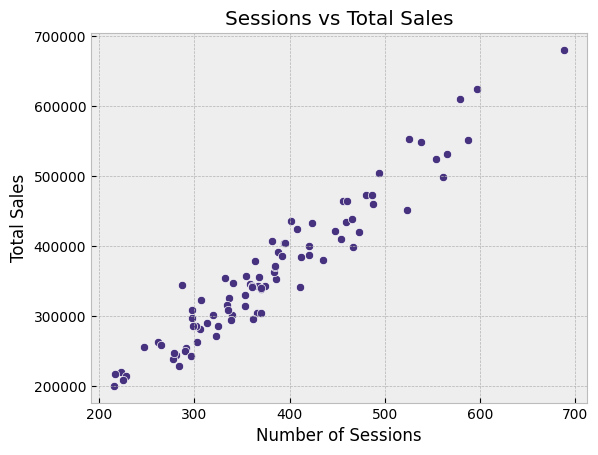

In [ ]:
sns.scatterplot(data=daily_sales_sessions, x='sessions', y='total_sales')
plt.title('Sessions vs Total Sales')
plt.xlabel('Number of Sessions')
plt.ylabel('Total Sales')

plt.show()

In [ ]:
r, p_value = pearsonr(daily_sales_sessions['sessions'], daily_sales_sessions['total_sales'])

print(f'Correlation: {r:.2f}')
print(f'p-value: {p_value:.2e}')

Correlation: 0.96
p-value: 2.24e-51


Для початку, отримуємо сильну кореляцію між кількістю сесій та обсягом продажів. Це означає відсутність якісних змін у структурі замовлень - середній обсяг залишається стабільним. Також це означає доцільність подальшого залучення покупців та збільшення обсягу замовлень.

In [ ]:
def plot_sales_correlation(df, column, period='date', plot=True):

    daily_sales = (
        df.groupby([period, column], observed=True)['price']
        .sum()
        .reset_index()
    )

    sales_pivot = daily_sales.pivot(index=period, columns=column, values='price')

    correlation = sales_pivot.corr()

    groups = sales_pivot.columns
    p_values = pd.DataFrame(index=groups, columns=groups)

    for g1, g2 in itertools.combinations_with_replacement(groups, 2):
        r, p = pearsonr(sales_pivot[g1], sales_pivot[g2])
        p_values.loc[g1, g2] = p
        p_values.loc[g2, g1] = p

    p_values = p_values.astype(float)

    if plot:
      plt.figure(figsize=(10, 8))
      sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
      plt.title(f'Кореляція між продажами у розрізі {column}')
      plt.show()

      plt.figure(figsize=(10, 8))
      sns.heatmap(p_values, annot=True, cmap='viridis_r', fmt='.2g')
      plt.title(f'p-value для кореляції між продажами у розрізі {column}')
      plt.show()

    return sales_pivot

In [ ]:
def plot_top_group_correlation(df, column, top_n, period='date', plot=True):

    top_values = (
        df.groupby(column, observed=True)['price']
        .sum()
        .nlargest(top_n)
        .index
    )

    df_top = df[df[column].isin(top_values)].copy()

    daily_sales = (
        df_top.groupby([period, column], observed=True)['price']
        .sum()
        .reset_index()
    )

    sales_pivot = daily_sales.pivot(
        index=period,
        columns=column,
        values='price'
    )

    correlation = sales_pivot.corr()

    p_values = pd.DataFrame(index=correlation.index, columns=correlation.columns)

    for v1, v2 in itertools.combinations_with_replacement(top_values, 2):
        r, p = pearsonr(sales_pivot[v1], sales_pivot[v2])
        p_values.loc[v1, v2] = p
        p_values.loc[v2, v1] = p

    p_values = p_values.astype(float)

    if plot:
      plt.figure(figsize=(8, 6))
      sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
      plt.title(f'Кореляція між продажами у розрізі {column}')
      plt.show()

      plt.figure(figsize=(8, 6))
      sns.heatmap(p_values, annot=True, cmap='viridis_r', fmt='.2e')
      plt.title(f'p-value для кореляції між продажами у розрізі {column}')
      plt.show()

    return sales_pivot

- Кореляція між кількістю продажами у розрізі девайсів

З наступної візуалізації можемо побачити сильний рівень кореляції між двома основними платформами - десктопними та мобільними девайсами. Однак, для тижневих продажів кореляція стає вищою між усіма групами.

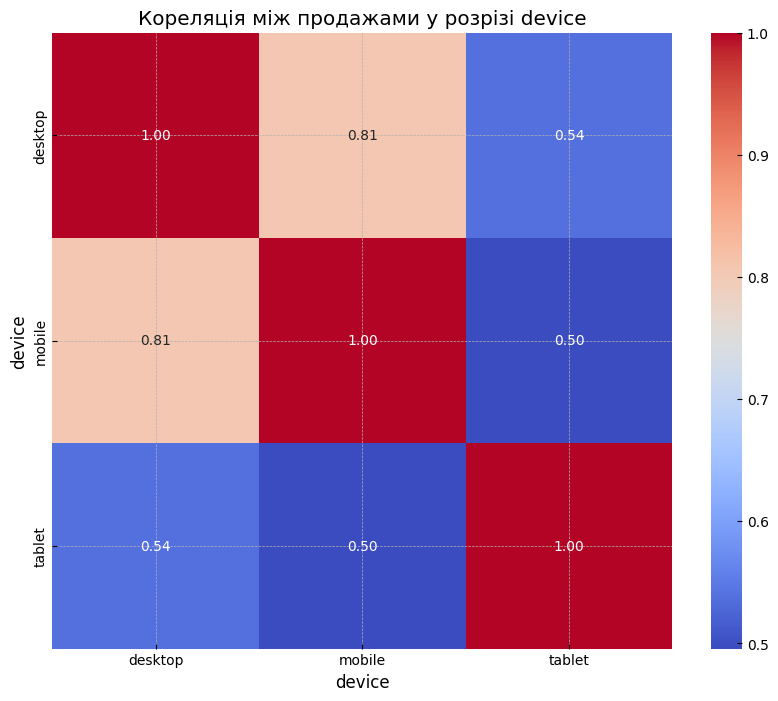

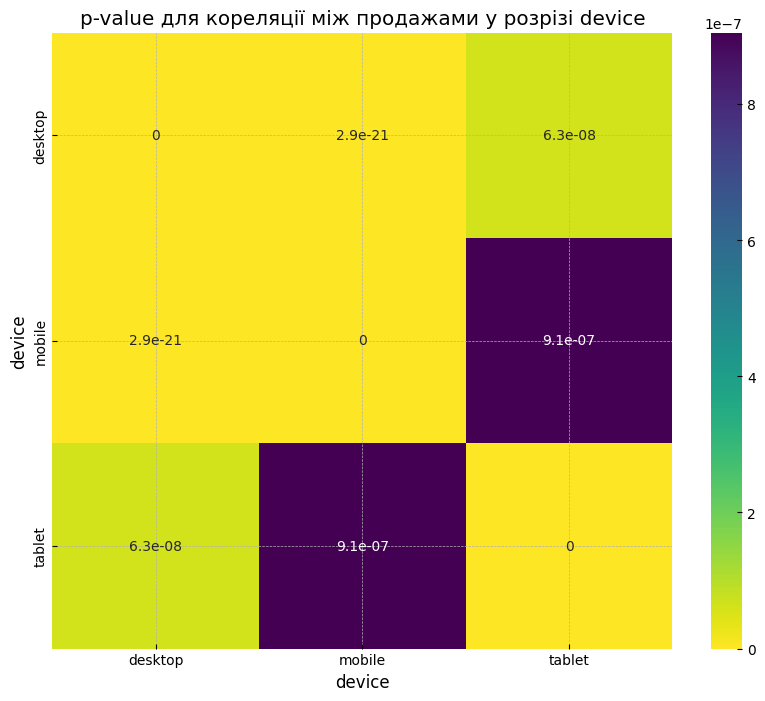

device,desktop,mobile,tablet
date,,,
2020-11-01,144445.0,99698.5,149.0
2020-11-02,206727.3,137269.5,11510.0
2020-11-03,304473.8,180602.8,13903.0
2020-11-04,212227.7,118324.4,8635.0
2020-11-05,249682.0,138256.0,3338.6
...,...,...,...
2021-01-23,174769.3,115462.2,374.0
2021-01-24,147218.2,93233.2,3367.0
2021-01-25,189441.7,107902.6,7745.0


In [ ]:
plot_sales_correlation(df, 'device')

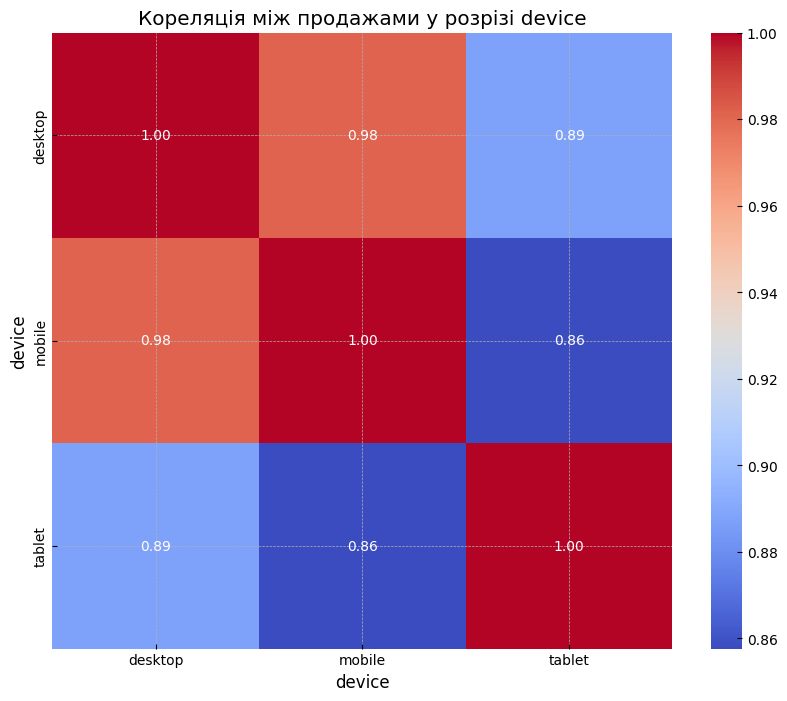

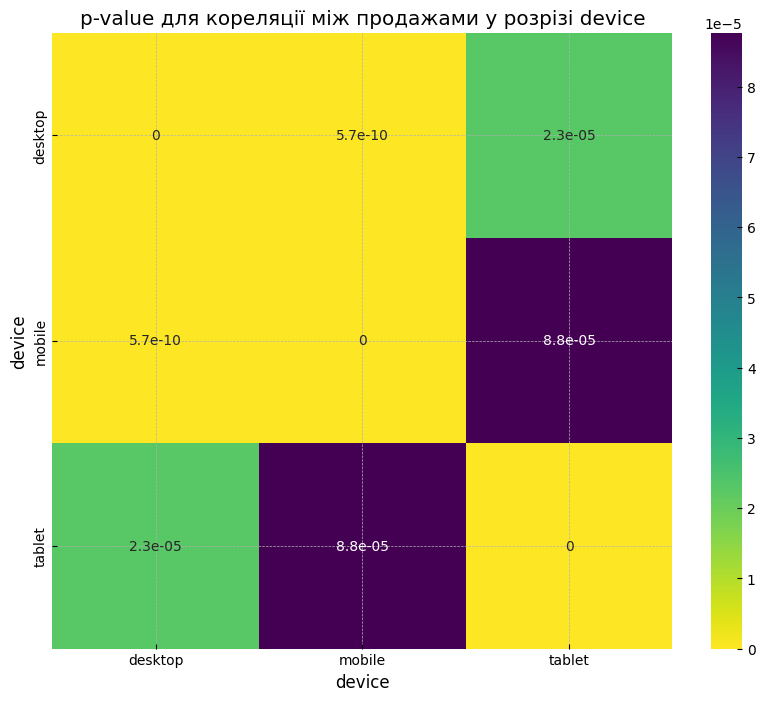

device,desktop,mobile,tablet
week,,,
2020-10-26,144445.0,99698.5,149.0
2020-11-02,1418306.2,858858.2,52482.6
2020-11-09,1146849.0,816646.6,47037.0
2020-11-16,1415479.0,961997.1,37438.0
2020-11-23,1500803.0,955300.6,62097.0
2020-11-30,1686432.3,1107315.9,71574.9
2020-12-07,2094036.8,1349872.4,106335.4
2020-12-14,1912849.6,1152754.6,80534.0
2020-12-21,1115497.9,872629.0,48222.4


In [ ]:
plot_sales_correlation(df, 'device', period='week')

- Кореляція між кількістю продажами у розрізі каналів залучення покупців

Схожу тенденцію можемо побачити і по каналам залучення покупців. Основні канали Direct, Organic Search та Paid Search мають високий рівень кореляції між собою і для денних, і для місячних продажів. Різниця в кореляції Social Search для денних та місячних продажів може свідчити про більш строковий характер впливу дій по розвитку даного каналу залучення покупців.

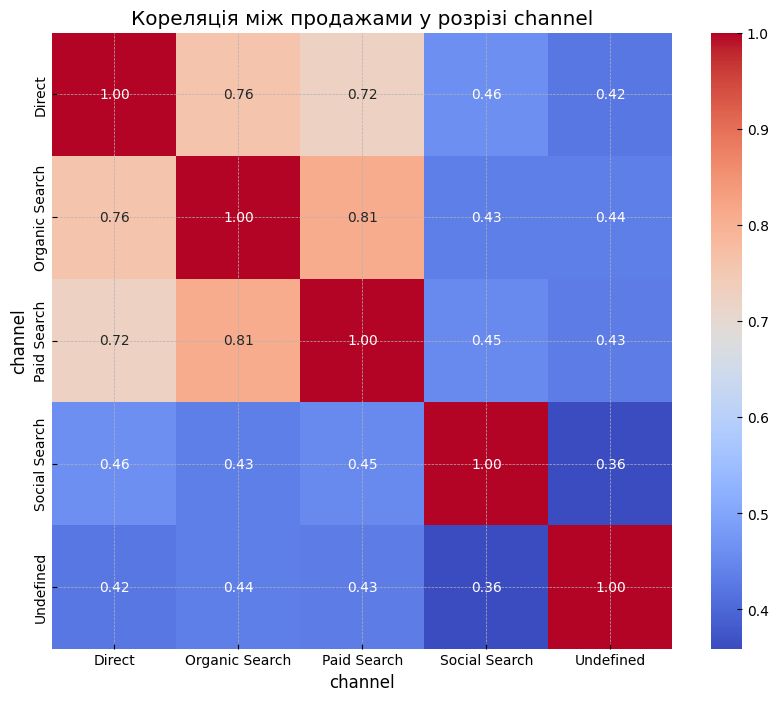

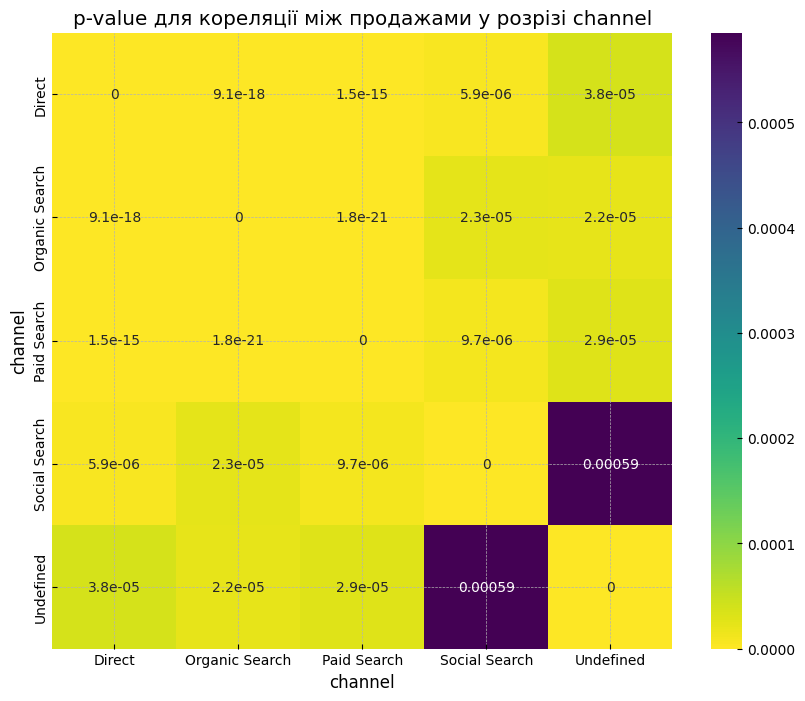

channel,Direct,Organic Search,Paid Search,Social Search,Undefined
date,,,,,
2020-11-01,54669.5,95112.0,64688.0,25078.0,4745.0
2020-11-02,81561.5,127746.5,104780.8,16843.0,24575.0
2020-11-03,102909.5,182521.9,152641.3,27652.5,33254.4
2020-11-04,79683.6,117067.1,100332.0,24257.4,17847.0
2020-11-05,83367.6,122938.4,107648.0,41693.2,35629.4
...,...,...,...,...,...
2021-01-23,88714.4,90686.0,73075.1,23095.0,15035.0
2021-01-24,58644.2,93413.6,59018.0,20596.1,12146.5
2021-01-25,67844.0,136178.6,66775.7,23809.0,10482.0


In [ ]:
plot_sales_correlation(df, 'channel')

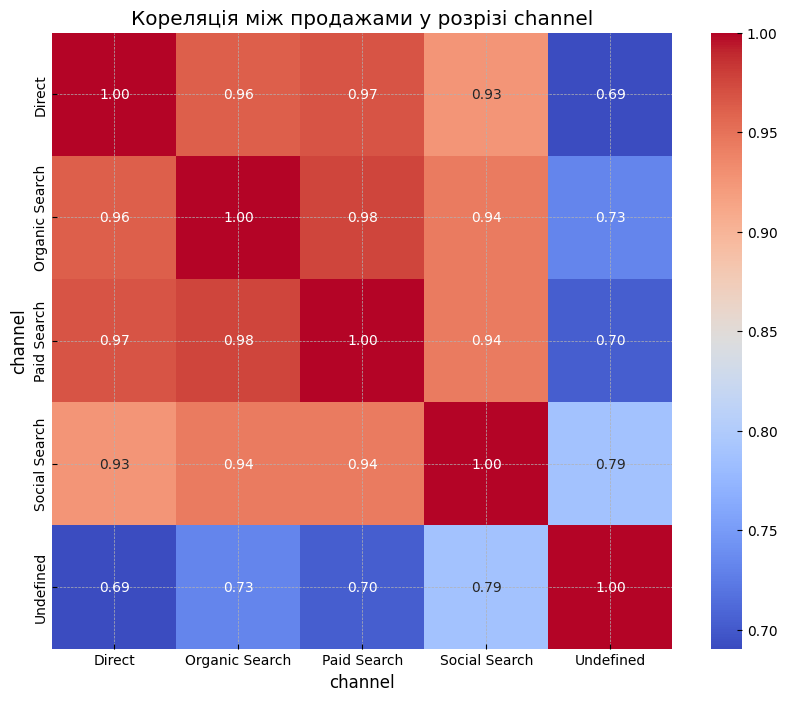

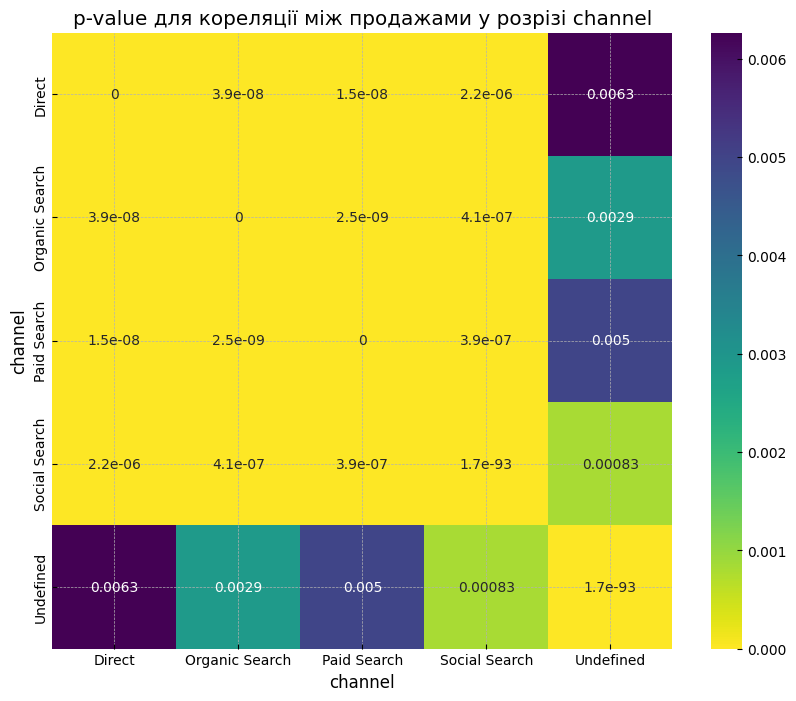

channel,Direct,Organic Search,Paid Search,Social Search,Undefined
week,,,,,
2020-10-26,54669.5,95112.0,64688.0,25078.0,4745.0
2020-11-02,509878.9,814653.2,624529.0,199037.1,181548.8
2020-11-09,540222.5,696301.2,510923.3,151153.2,111932.4
2020-11-16,571398.2,781434.3,599067.8,195470.0,267543.8
2020-11-23,588721.3,862593.3,666230.7,207604.8,193050.5
2020-11-30,595065.5,1079952.5,715488.3,233930.4,240886.4
2020-12-07,775774.7,1346086.5,930790.6,267772.3,229820.5
2020-12-14,749505.8,1128215.1,805867.1,297721.2,164829.0
2020-12-21,430380.9,706327.1,608551.8,175331.5,115758.0


In [ ]:
plot_sales_correlation(df, 'channel', period='week')

- Кореляція між кількістю продажами у розрізі континентів

Наступні розрахунки та візуалізації показують, що динаміка змін обсягів продажів за континентами сильно корелює між собою на тижневому періоді, що може свідчити про схожість тенденцій розвитку ринку на даних континентах впродовж розглянутого періоду.

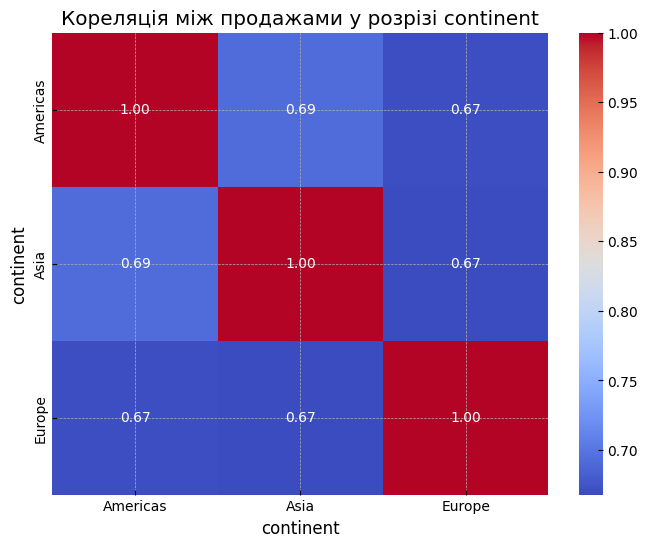

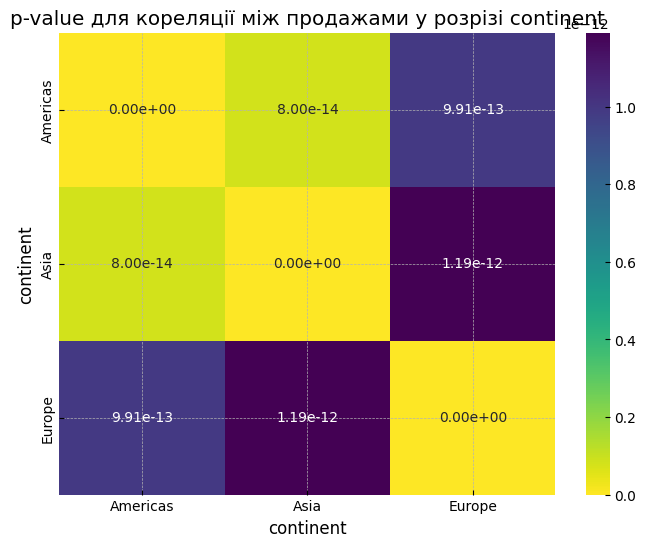

continent,Americas,Asia,Europe
date,,,
2020-11-01,132002.5,63823.0,46908.0
2020-11-02,193861.0,79370.0,75710.8
2020-11-03,294529.8,126737.8,67692.0
2020-11-04,200009.5,66602.0,65915.0
2020-11-05,182988.2,117608.4,86540.0
...,...,...,...
2021-01-23,155342.9,68543.0,62883.6
2021-01-24,116989.4,74801.2,47534.8
2021-01-25,182548.1,66215.2,55621.0


In [ ]:
plot_top_group_correlation(df, 'continent', 3)

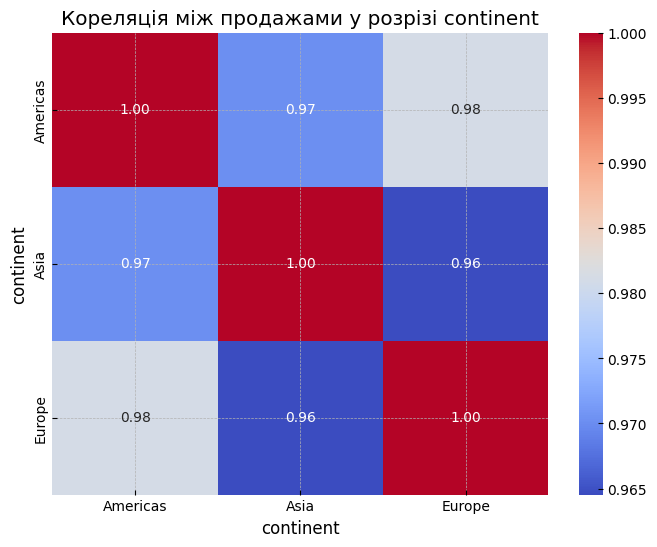

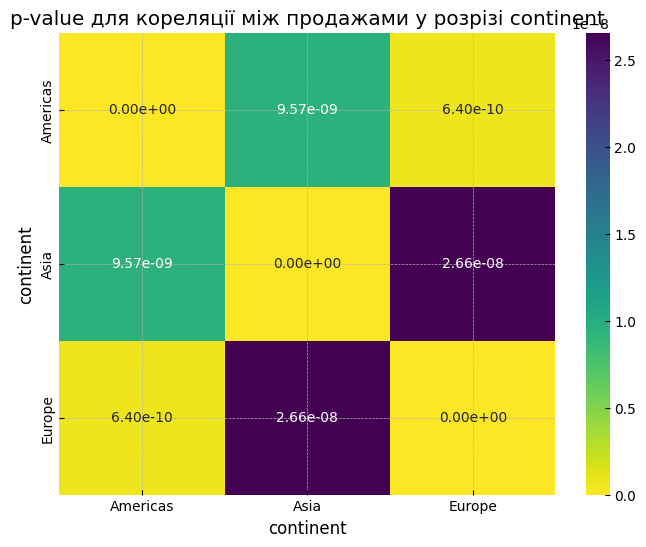

continent,Americas,Asia,Europe
week,,,
2020-10-26,132002.5,63823.0,46908.0
2020-11-02,1249284.6,575723.4,460003.4
2020-11-09,1045330.9,531386.3,364326.0
2020-11-16,1353865.0,596597.9,416527.7
2020-11-23,1433004.3,551812.0,464820.4
2020-11-30,1600256.8,645476.9,546211.4
2020-12-07,1946409.7,821805.9,692069.4
2020-12-14,1735085.9,796873.0,541534.7
2020-12-21,1170444.7,415209.1,392878.5


In [ ]:
plot_top_group_correlation(df, 'continent', 3, period='week')

- Кореляція між кількістю продажами у розрізі категорій товарів

Схожа ситуація спостерігається і для категорій товарів - середній рівень кореляції між категоріями для денного періоду та високий для тижневого.

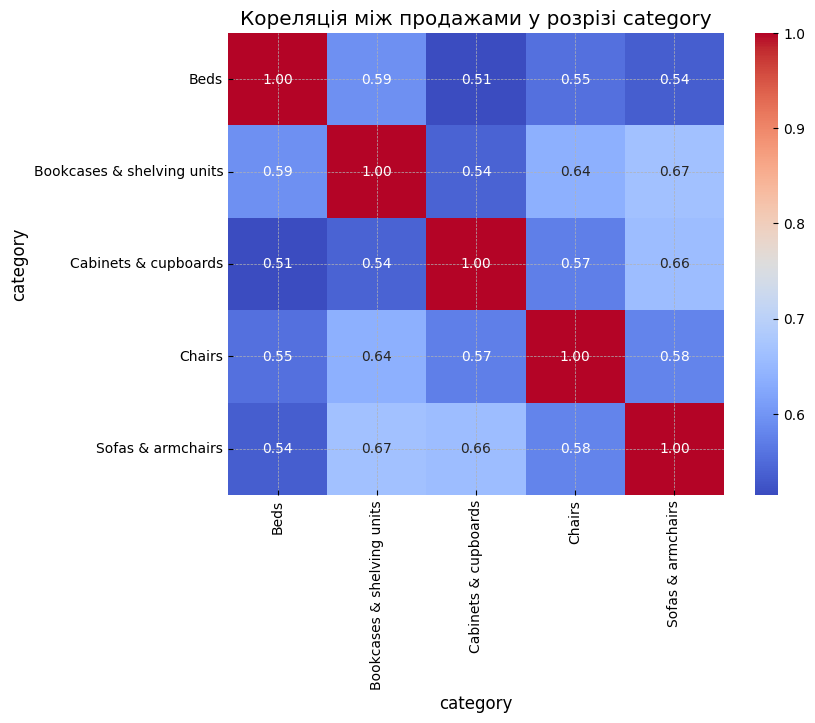

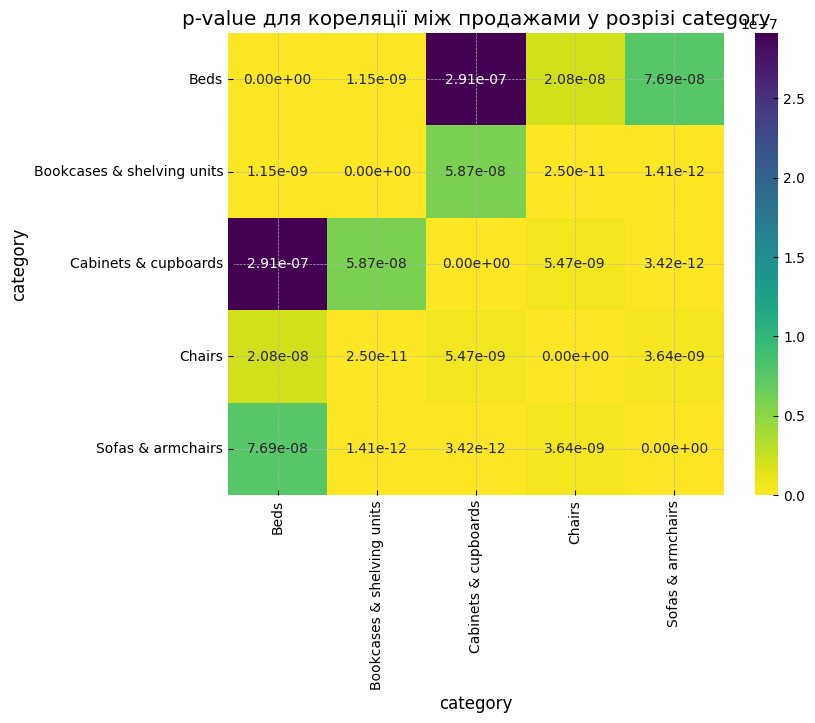

category,Beds,Bookcases & shelving units,Cabinets & cupboards,Chairs,Sofas & armchairs
date,,,,,
2020-11-01,14041.0,36701.0,13591.5,46006.0,75216.0
2020-11-02,79683.5,40979.0,21623.0,58834.0,79977.5
2020-11-03,66219.5,64360.1,33555.5,61204.0,175594.0
2020-11-04,48939.0,35719.8,19266.0,44113.0,86861.5
2020-11-05,23449.0,40998.8,29235.0,90388.4,137288.0
...,...,...,...,...,...
2021-01-23,37116.0,29862.7,26068.0,57493.0,76898.0
2021-01-24,23294.0,25396.0,23664.5,54288.0,57837.0
2021-01-25,47303.5,25919.6,33028.0,51424.2,84544.0


In [ ]:
plot_top_group_correlation(df, 'category', 5)

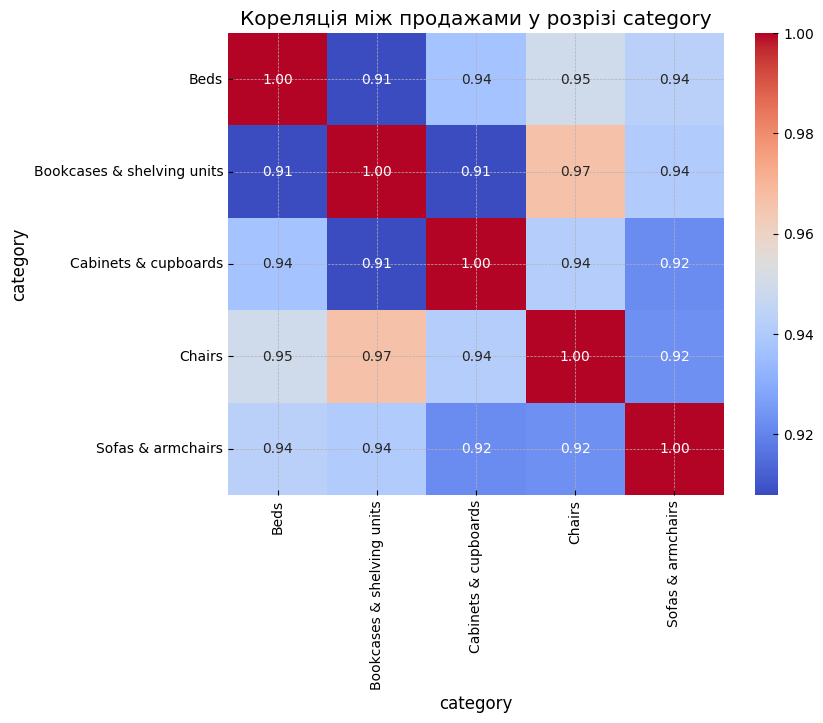

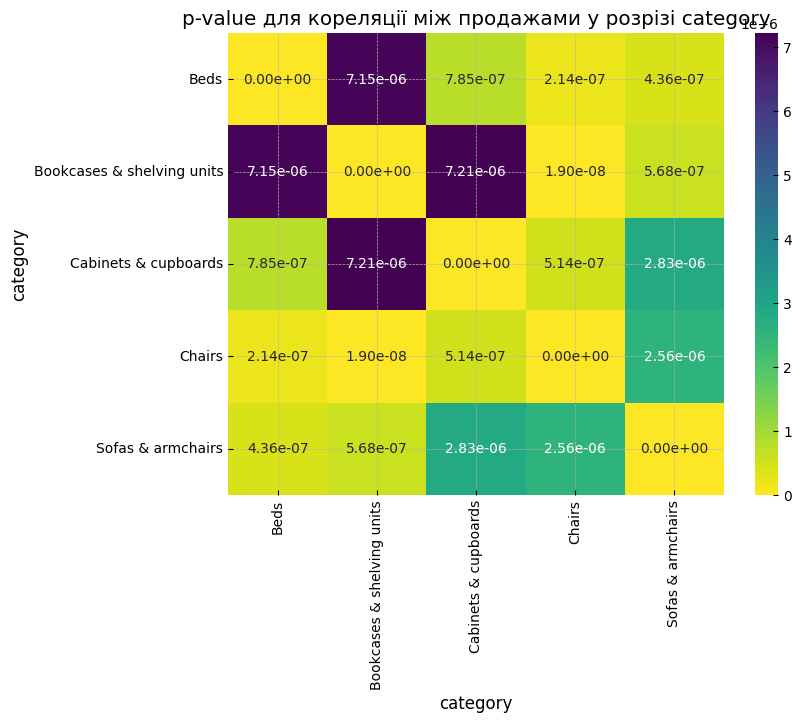

category,Beds,Bookcases & shelving units,Cabinets & cupboards,Chairs,Sofas & armchairs
week,,,,,
2020-10-26,14041.0,36701.0,13591.5,46006.0,75216.0
2020-11-02,335099.0,260351.7,145214.5,421304.4,669374.0
2020-11-09,236442.5,253639.9,146603.0,378425.8,561698.5
2020-11-16,350709.5,301424.5,182395.0,439749.8,686031.0
2020-11-23,411150.0,273083.5,196376.5,427134.8,697213.5
2020-11-30,430276.5,347343.7,220410.5,636390.4,648537.5
2020-12-07,566849.5,344559.9,291791.0,649183.6,916836.5
2020-12-14,474512.0,391850.6,238630.0,629402.8,777688.5
2020-12-21,371769.0,238337.8,143518.0,400187.8,513467.5


In [ ]:
plot_top_group_correlation(df, 'category', 5, period='week')

Низькі значення p-value при всіх розрахунках свідчать про їх статистичну значущість.

Отже, загалом результати цієї частини дослідження показали, що ринок компанії у даному періоді розвивався стабільно у багатьох аспектах - як по територіальному розподілу, так і в розподілах у розрізі каналів та девайсів. Це може свідчити про те, що компанія має стійкий бізнес, який показав стабільну поведінку у такий період як святковий.

In [ ]:
df['has_account'].value_counts()

,count
has_account,
not_registered,30757
registered,2781


**4. На цьому етапі дослідження проведемо аналіз відмінностей між групами.**

Спочатку проаналізуємо наявність відмінностей між продажами для зареєстрованих та незареєстрованих користувачів.

Спершу проаналізуємо характер розподілу

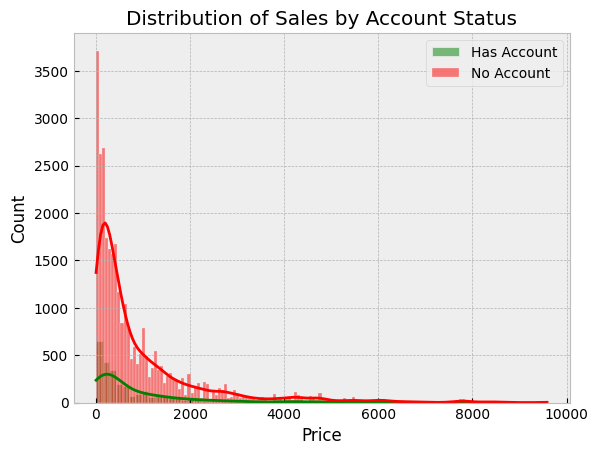

Тест Шапіро для зареєстрованих користувачів: p = 4.21e-59
Тест Шапіро для незареєстрованих користувачів: p = 5.58e-71


In [ ]:
registered = df[df['has_account'] == 'registered']['price']
not_registered = df[df['has_account'] == 'not_registered']['price']

sns.histplot(registered, kde=True, label='Has Account', color='green')
sns.histplot(not_registered, kde=True, label='No Account', color='red')
plt.legend()
plt.title('Distribution of Sales by Account Status')
plt.xlabel('Price')
plt.show()

stat_registered, p_registered = shapiro(registered.sample(min(5000, len(registered))))
stat_not_registered, p_not_registered = shapiro(not_registered.sample(min(5000, len(not_registered))))

print(f'Тест Шапіро для зареєстрованих користувачів: p = {p_registered:.2e}')
print(f'Тест Шапіро для незареєстрованих користувачів: p = {p_not_registered:.2e}')

Візуальний розподіл та тест Шапіро показують відсутність нормального розподілу. Враховуючи це, використаємо непараметричний тест Манна-Уітні.

In [ ]:
t_stat, p_val = mannwhitneyu(registered, not_registered)
print(f'Тест Манна-Уітні: p-value = {p_val:.4f}')

df.groupby('has_account')['price'].mean().round(2)

Тест Манна-Уітні: p-value = 0.0416


,price
has_account,
not_registered,955.53
registered,928.63


p-value менше 0.05 свідчить про статистичну значущість різниці для індивідуальних замовлень.

Також проведемо аналогічні розрахунки для денних замовлень.

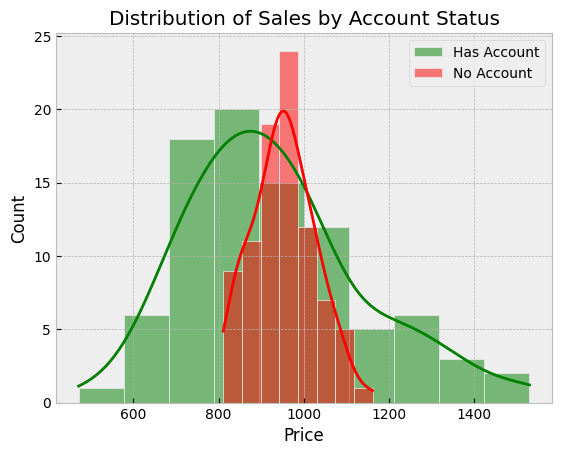

Тест Шапіро для зареєстрованих користувачів: p = 0.0129
Тест Шапіро для незареєстрованих користувачів: p = 0.5102


In [ ]:
daily_avg = df.groupby(['date', 'has_account'])['price'].mean().reset_index()

registered_daily = daily_avg[daily_avg['has_account'] == 'registered']['price']
not_registered_daily = daily_avg[daily_avg['has_account'] == 'not_registered']['price']

sns.histplot(registered_daily, kde=True, label='Has Account', color='green')
sns.histplot(not_registered_daily, kde=True, label='No Account', color='red')
plt.legend()
plt.title('Distribution of Sales by Account Status')
plt.xlabel('Price')
plt.show()

stat_registered, p_registered = shapiro(registered_daily)
stat_not_registered, p_not_registered = shapiro(not_registered_daily)

print(f'Тест Шапіро для зареєстрованих користувачів: p = {p_registered:.4f}')
print(f'Тест Шапіро для незареєстрованих користувачів: p = {p_not_registered:.4f}')

Тест вказує на вірогідну відсутність нормального розподілу для зареєстрованих користувачів.

In [ ]:
t_stat, p_val = mannwhitneyu(registered_daily, not_registered_daily, alternative='two-sided')
print(f'Тест Манна-Уітні: p-value = {p_val:.4f}')

print(f'Щоденна середня для зареєстрованих користувачів: {registered_daily.mean().round(2)}')
print(f'Щоденна середня для незареєстрованих користувачів: {not_registered_daily.mean().round(2)}')

Тест Манна-Уітні: p-value = 0.0340
Щоденна середня для зареєстрованих користувачів: 930.73
Щоденна середня для незареєстрованих користувачів: 953.05


Отже, p-value менше 0.05 також вказує на статистичну значущість різниці.

Також згадаємо один з результатів з минулого етапу дослідження у розрізі аккаунтів зі статусом підтвердження електронної адреси.

In [ ]:
accounts_by_verif.style\
      .set_caption('Порівняння аккаунтів за статусом підтвердження електронної адреси')\
      .format({
        'total_sales': '{:,.2f}',
        'avg_sales': '{:,.2f}',
        'pct_orders': '{:.2f}%',
        'pct_sales': '{:.2f}%'
          })

,is_verified,orders,total_sales,avg_sales,pct_orders,pct_sales
0,1,1989,"1,866,017.40",938.17,71.52%,72.26%
1,0,792,"716,501.10",904.67,28.48%,27.74%


Більш детально дослідимо статистичну значущість різниці.

In [ ]:
verified = df[df['is_verified'] == 1]['price']
not_verified = df[df['is_verified'] == 0]['price']

stat_verified, p_verified = shapiro(verified)
stat_not_verified, p_not_verified = shapiro(not_verified)

print(f'Тест Шапіро для користувачів з підтвердженою поштою: {p_verified}')
print(f'Тест Шапіро для користувачів з непідтвердженою поштою: {p_not_verified}')

Тест Шапіро для користувачів з підтвердженою поштою: 2.8098573159513303e-52
Тест Шапіро для користувачів з непідтвердженою поштою: 3.3425114844225247e-37


Низьке значення p-value для тесту Шапіро свідчить про вірогідну відсутність нормального розподілу, тому надалі застосуємо тест Манна-Уітні.

In [ ]:
stat, p = mannwhitneyu(verified, not_verified, alternative='two-sided')

print(f'p-value = {p:.4f}')

p-value = 0.2704


Високе значення p-value показує відсутність статистичної значущості різниці.

Окрім цього, згадаємо розподіл по статусу підписки. Проведемо аналогічний аналіз і в цьому випадку.

In [ ]:
accounts_by_sub.style\
      .set_caption('Порівняння аккаунтів за підпискою')\
      .format({
        'total_sales': '{:,.2f}',
        'avg_sales': '{:,.2f}',
        'pct_orders': '{:.2f}%',
        'pct_sales': '{:.2f}%'
          })

,is_unsubscribed,orders,total_sales,avg_sales,pct_orders,pct_sales
0,0,2334,"2,150,796.90",921.51,83.93%,83.28%
1,1,447,"431,721.60",965.82,16.07%,16.72%


Також проведемо дослідження наявності чи відсутності відмінностей між щоденною кількістю сесій для каналів залучення користувачів.

In [ ]:
unsub = df[df['is_unsubscribed'] == 1]['price']
sub = df[df['is_unsubscribed'] == 0]['price']

stat_unsub, p_unsub = shapiro(unsub)
stat_sub, p_sub = shapiro(sub)

print(f'Тест Шапіро для користувачів з підтвердженою поштою: {p_unsub}')
print(f'Тест Шапіро для користувачів з непідтвердженою поштою: {p_sub}')

Тест Шапіро для користувачів з підтвердженою поштою: 1.1328534757663367e-27
Тест Шапіро для користувачів з непідтвердженою поштою: 6.810968784476892e-56


In [ ]:
stat, p = mannwhitneyu(unsub, sub, alternative='two-sided')

print(f'p-value = {p:.4f}')

p-value = 0.1678


У даному випадку значення p-value також вказує на відсутність статистичної значущості різниці.

In [ ]:
daily_sessions = (
    df.groupby(['date', 'channel'], observed=True)['ga_session_id']
    .count()
    .reset_index(name='daily_sessions')
)

groups = []
channels = daily_sessions['channel'].unique()

for channel in channels:
    group_data = daily_sessions[daily_sessions['channel'] == channel]['daily_sessions']
    groups.append(group_data)

stat, p = kruskal(*groups)

print(f'Результат тесту Крушкала-Уоллеса: p-value = {p:.2e}')

Результат тесту Крушкала-Уоллеса: p-value = 2.33e-74


Отже, результат тесту показав, що з-поміж 5 груп у деяких з них є відмінності. Далі визначимо, у яких саме.

In [ ]:
dunn_result = sp.posthoc_dunn(
    daily_sessions,
    val_col='daily_sessions',
    group_col='channel',
    p_adjust='bonferroni'
)

dunn_result.style\
    .format('{:.4f}')\
    .map(lambda v: 'background-color: lightgreen' if v < 0.05 else '')

,Direct,Organic Search,Paid Search,Social Search,Undefined
Direct,1.0000,0.0000,0.5913,0.0000,0.0000
Organic Search,0.0000,1.0000,0.0034,0.0000,0.0000
Paid Search,0.5913,0.0034,1.0000,0.0000,0.0000
Social Search,0.0000,0.0000,0.0000,1.0000,0.7370
Undefined,0.0000,0.0000,0.0000,0.7370,1.0000


Можемо побачити, що схожими між собою є групи Direct та Paid Search, а також Social Search та Undefined. Всі інші комбінації груп є відмінними між собою.

Окрім цього, проведемо аналіз статистичної різниці між долями сесій Organic Search у Європі та Америці.

In [ ]:
df_filtered = df[df['continent'].isin(['Europe', 'Americas'])].copy()

total_sessions = (
    df_filtered.groupby('continent', observed=True)['ga_session_id']
    .count()
    .to_dict()
)

organic_sessions = (
    df_filtered[df_filtered['channel'] == 'Organic Search']
    .groupby('continent', observed=True)['ga_session_id']
    .count()
    .to_dict()
)

continents = ['Europe', 'Americas']
organic_counts = [organic_sessions[continent] for continent in continents]
totals = [total_sessions[continent] for continent in continents]

stat, p_value = proportions_ztest(count=organic_counts, nobs=totals)

print(f'p-value = {p_value:.4f}')

p-value = 0.4600


Отримана величина p-value вказує на відсутність статистично значущої різниці.

Також дослідимо різницю між величинами замовлень та між каналами залучення покупців у Франції та Великобританії, оскільки у даних країнах спостерігалась значна різниця у середній величині замовлення.

In [ ]:
orders_and_sales[['country', 'sales_per_order', 'pct_from_total_sales']].reset_index(drop=True)\
    .style\
    .set_caption('Середня ціна замовлення у розрізі країн')\
    .format({
        'sales_per_order': '{:.2f}',
        'pct_from_total_sales': '{:.2f}%'
    })

,country,sales_per_order,pct_from_total_sales
0,France,1048.22,2.22%
1,Other,962.18,34.76%
2,Canada,952.31,7.63%
3,United States,950.29,43.61%
4,India,927.62,8.79%
5,United Kingdom,911.87,2.93%


In [ ]:
sales_france = df[df['country'] == 'France']['price']
sales_uk = df[df['country'] == 'United Kingdom']['price']

stat_fr, p_fr = shapiro(sales_france)
stat_uk, p_uk = shapiro(sales_uk)

print(f'p-value теста Шапіро для Франції = {p_fr:.2e}')
print(f'p-value теста Шапіро для Великобританії = {p_uk:.2e}')

p-value теста Шапіро для Франції = 1.12e-33
p-value теста Шапіро для Великобританії = 1.14e-40


In [ ]:
stat, p = mannwhitneyu(sales_france, sales_uk, alternative='two-sided')
print(f'p-value тесту Манна-Уітні: {p}')

p-value тесту Манна-Уітні: 0.1234881865043268


Отже, враховуючи величину p-value вище 0.05, статистичної значущості різниці у величинах замовлень не виявлено.

Також порівняємо структуру замовлень по каналам залучення покупців.

In [ ]:
merged_channels_fr_uk[['channel', 'orders_france', 'orders_uk']].style\
    .set_caption('Порівняння каналів залучення покупців у Франції та Великобританії')

,channel,orders_france,orders_uk
0,Organic Search,247,379
1,Paid Search,191,289
2,Direct,156,236
3,Social Search,45,73
4,Undefined,39,52


In [ ]:
df_orders_france_uk = merged_channels_fr_uk[['channel', 'orders_france', 'orders_uk']]

contingency_table = df_orders_france_uk.set_index('channel')[['orders_france', 'orders_uk']]

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f'Chi-square p-value = {p:.4f}')

Chi-square p-value = 0.9717


Отже, високе значення p-value свідчить про відсутність статистично значущої різниці між розподілом замовлень по категоріям.

##Загальні висновки до проведеного дослідження:

- Отже, був проведений аналіз діяльності інтернет-магазину меблів за 3-х місячний період. Розглянутий період припадав на різдвяні та новорічні свята, що позначилося на показниках динаміки (підйом до середини грудня і спад після);
- Бізнес проводить доставку до багатьох країн світу. Основний ринок - американський континент (близько 55% продажів), також суттєве представництво Європи та Азії (близько 19 та 24% відповідно);
- Денна циклічність суттєво згладжується вже на тижневому періоді. Загалом, для оцінки циклічності такого бізнесу в цілому потрібен довший часовий діапазон, тим більше рід товарів (меблі) є відносно нерегулярними покупками;
- Більшість покупців (близько 91%) не має статусу зареєстрованих. Також показник середньої покупки виявився нижчим для зареєстрованого користувача у розглянутому періоді. Однак, доцільніше аналізувати подібну різницю на довшому періоді, ніж 3 місяці, оскільки реєстрація є частиною вибудови довгострокових відносин з клієнтами (чим більший період, тим більша роль повторних покупок);
- З-поміж девайсів переважають покупки з десктопу (близько 59%). Вони є також вищими і по величині середнього чеку;
- У питанні каналів залучення покупців компанія розвиває різні напрямки, три з яких є основними - Direct search, Organic search та Paid search. Варто відмітити, що середній чек для Direct search та Organic search є вищим за аналогічний показник для Paid search.

В цілому, отримані висновки (як загальні, там і по ходу дослідження) не можна вважати остаточними і повними через обмеження у періоді дослідження. Вірогідно, оптимальніше було б розглянути річний період, який дав би більш повну картину з урахуванням циклічності.


Коротка презентація основних показників компанії у Tableau: [Презентація](https://public.tableau.com/views/Shop_analysis_17506827512840/SalesPerformanceAudienceBreakdown?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link)